# **Delivery Time Estimation**

#### **Problem**

The business constantly working to improve its service for customers and life and earnings of their delivery partners. They want to evaluate the Estimated Delivery Time on the basis of
- What they are ordering?
- From Where they are ordering
- The availability of Delivery Partners
- etc

> I'll explore the data to find hidden stories and since this is a Regression task, I'll use Neural Networks to estimate the same.

# Data Initialization

In [6]:
# Importing required libraries
from pyspark.sql import SparkSession

In [7]:
# Pyspark Java Setup

# import os

# Set the JAVA_HOME environment variable

# os.environ['JAVA_HOME'] = '/home/studio-lab-user/.conda/envs/delivery_time_torch'
# os.environ['PATH'] = os.environ['JAVA_HOME'] + '/bin:' + os.environ['PATH']

In [8]:
# Initializing Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()

24/06/20 12:21:25 WARN Utils: Your hostname, Bharats-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.39 instead (on interface en0)
24/06/20 12:21:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/20 12:21:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [9]:
# Adjust Spark session settings to improve display
spark.conf.set("spark.sql.repl.eagerEval.maxNumRows", 50)
spark.conf.set("spark.sql.repl.eagerEval.truncate", 100)
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [10]:
# Investigating Dataset
df = spark.read.csv('../data/raw/data.csv', header=True, inferSchema=True)
display(df.limit(5))

market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0
2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0
3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NULL,1.0,1,1900,1,1900,1900,1.0,0.0,0.0
3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NULL,1.0,6,6900,5,600,1800,1.0,1.0,2.0
3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NULL,1.0,3,3900,3,1100,1600,6.0,6.0,9.0


24/06/20 12:21:40 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [10]:
# Shape of the dataset

print(f"Shape of DataFrame: (rows: {df.count()}, columns: {len(df.columns)})")

Shape of DataFrame: (rows: 197428, columns: 14)


**Observe**
- We have 14 features and almost 200K datapoints.
- Data seems to be of descent small size.

In [11]:
# Datatypes Info
df.printSchema()

root
 |-- market_id: double (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- actual_delivery_time: timestamp (nullable = true)
 |-- store_id: string (nullable = true)
 |-- store_primary_category: string (nullable = true)
 |-- order_protocol: double (nullable = true)
 |-- total_items: integer (nullable = true)
 |-- subtotal: integer (nullable = true)
 |-- num_distinct_items: integer (nullable = true)
 |-- min_item_price: integer (nullable = true)
 |-- max_item_price: integer (nullable = true)
 |-- total_onshift_partners: double (nullable = true)
 |-- total_busy_partners: double (nullable = true)
 |-- total_outstanding_orders: double (nullable = true)



In [12]:
# Filtering columns on the basis of Data Types

from pyspark.sql.types import StringType, NumericType, TimestampType

continuous_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]
categorical_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]
temporal_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, TimestampType)]

In [13]:
# Null Values

from pyspark.sql.functions import col, count, when

df.select([count(when(col(c).isNull(),c)).alias(c) for c in df.columns]).toPandas().transpose()/df.count() * 100

,0
market_id,0.499929
created_at,0.000000
actual_delivery_time,0.003546
store_id,0.000000
store_primary_category,2.411006
order_protocol,0.503981
total_items,0.000000
subtotal,0.000000
num_distinct_items,0.000000
min_item_price,0.000000


**Observe**
- Need to treat many Null Values, Cannot drop.

In [14]:
# Statistics Summary
df.select(*continuous_cols).summary().toPandas().transpose()

,0,1,2,3,4,5,6,7
summary,count,mean,stddev,min,25%,50%,75%,max
market_id,196441,2.978706074597462,1.5248667244506318,1.0,2.0,3.0,4.0,6.0
order_protocol,196433,2.8823517433425137,1.5037712034995814,1.0,1.0,3.0,4.0,7.0
total_items,197428,3.196390582896043,2.666546063599881,1,2,3,4,411
subtotal,197428,2682.331401827502,1823.0936878547877,0,1400,2200,3395,27100
num_distinct_items,197428,2.6707913771096297,1.6302552413381575,1,1,2,3,20
min_item_price,197428,686.2184695180015,522.0386476914739,-86,299,595,949,14700
max_item_price,197428,1159.5886297789573,558.4113766592682,0,800,1095,1395,14700
total_onshift_partners,181166,44.808093130057514,34.5267834762135,-4.0,17.0,37.0,65.0,171.0
total_busy_partners,181166,41.739746972389966,32.14573271803179,-5.0,15.0,34.0,62.0,154.0


**Observe**
- Higher Outliers observed in Subtotals, indicating the field is affected by extremes.
- Also thorough investigation is required for the Negative values observed in the Item price, orders and partners.

In [15]:
# Unique Values Observed

from pyspark.sql.functions import countDistinct

df.agg(*(countDistinct(c).alias(c) for c in df.columns)).toPandas().transpose()

,0
market_id,6
created_at,180985
actual_delivery_time,178110
store_id,6743
store_primary_category,74
order_protocol,7
total_items,57
subtotal,8368
num_distinct_items,20
min_item_price,2312


In [16]:
# Analyze Value counts for Low Cardinal features

from pyspark.sql.functions import lit,col,round

low_cardinal = ["market_id", "order_protocol"]
for c in low_cardinal:
    display(df.groupby(c).count().withColumn( "normalized_count", round(col("count")/lit(df.count()) * 100,2) ))

market_id,count,normalized_count
NULL,987,0.5
1.0,38037,19.27
4.0,47599,24.11
3.0,23297,11.8
2.0,55058,27.89
6.0,14450,7.32
5.0,18000,9.12


order_protocol,count,normalized_count
7.0,19,0.01
NULL,995,0.5
1.0,54725,27.72
4.0,19354,9.8
3.0,53199,26.95
2.0,24052,12.18
6.0,794,0.4
5.0,44290,22.43


**Observe**
- marked_id of 2 dominates the market.
- order_protocol 1 & 3 , most common protocols used to place order.

In [17]:
# Duplicate Records
df.exceptAll(df.dropDuplicates()).count()

0

# Exploratory Data Analysis

In [18]:
# Assigning Discrete Numerical Cols to Categorical cols
discrete_cols = [ "market_id","order_protocol","num_distinct_items"]

for c in discrete_cols:
    continuous_cols.remove(c)
    categorical_cols.append(c)

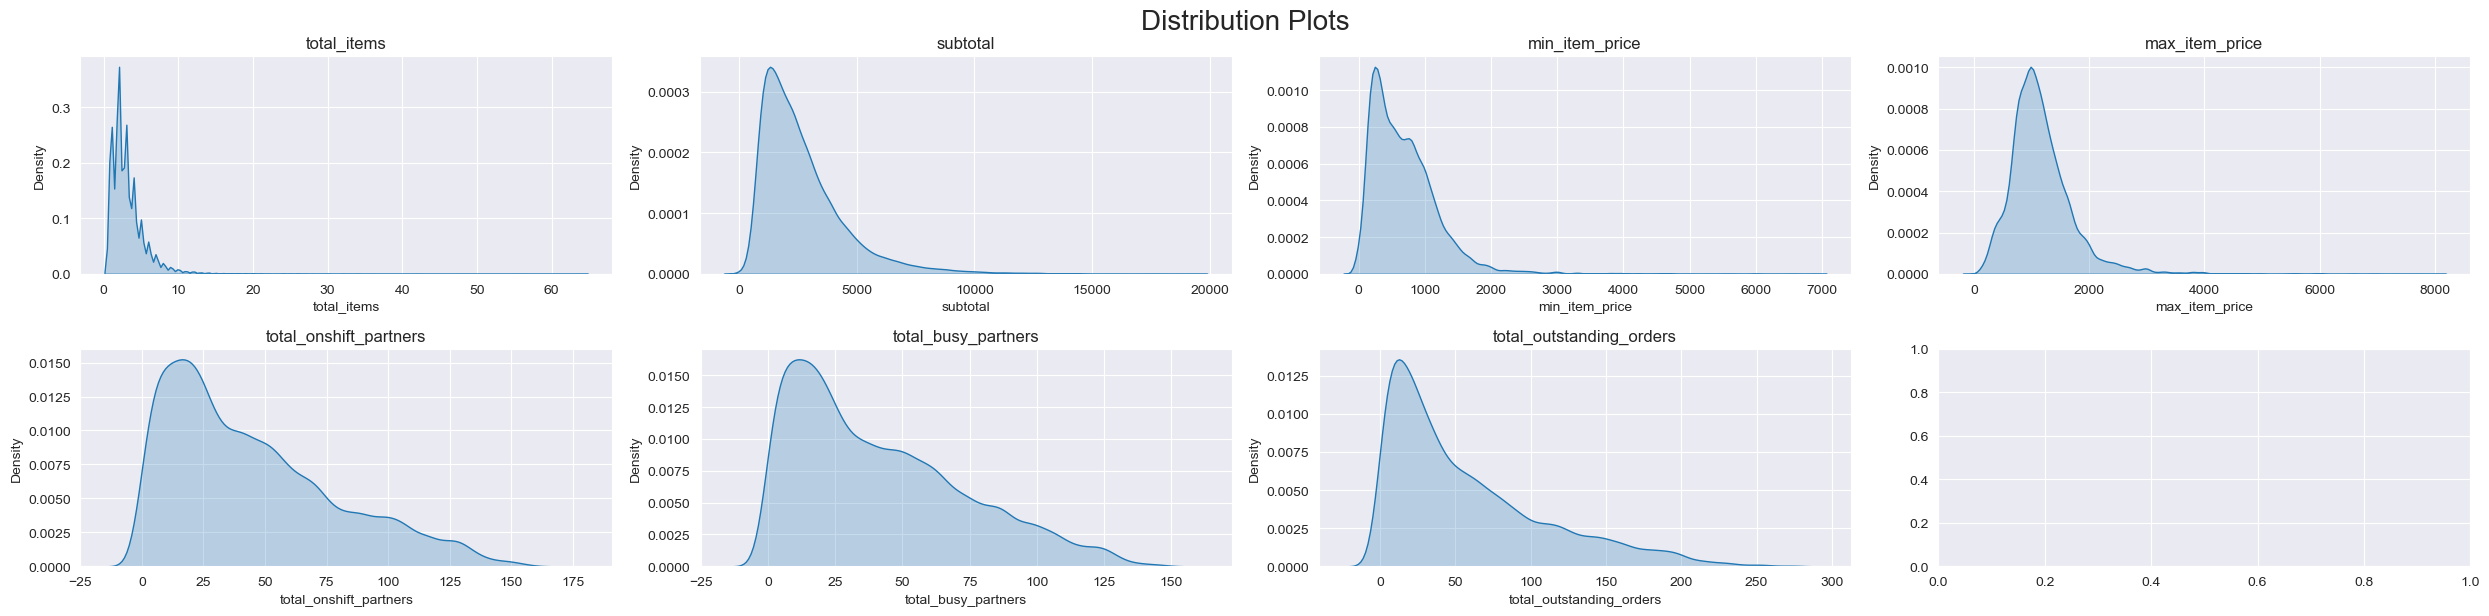

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# sns.set_palette("Set2")
sns.set_style('darkgrid')
# plt.style.use('dark_background')

pandas_df = df.dropna().sample(False,fraction = 0.25,seed=42).toPandas()

nrows = (len(continuous_cols) // 4) + (len(continuous_cols) % 2)

fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(25, 3 * nrows))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through each continuous column to create distribution plots
for i, feature in enumerate(continuous_cols):
    sns.kdeplot(data=pandas_df, x=feature, fill=True, ax=axes[i] )
    axes[i].set_title(feature)

# Adjust layout
plt.tight_layout()
plt.suptitle("Distribution Plots", y=1.02, fontsize=20)
plt.show()

**Observe**
- All the distribution seems to be a part od **Log Normal** Distribution (We need to handle negative values since Log Normal can never have value less than 0 or 0).
- `total_items` is highly skewed indicating large presence of outliers.

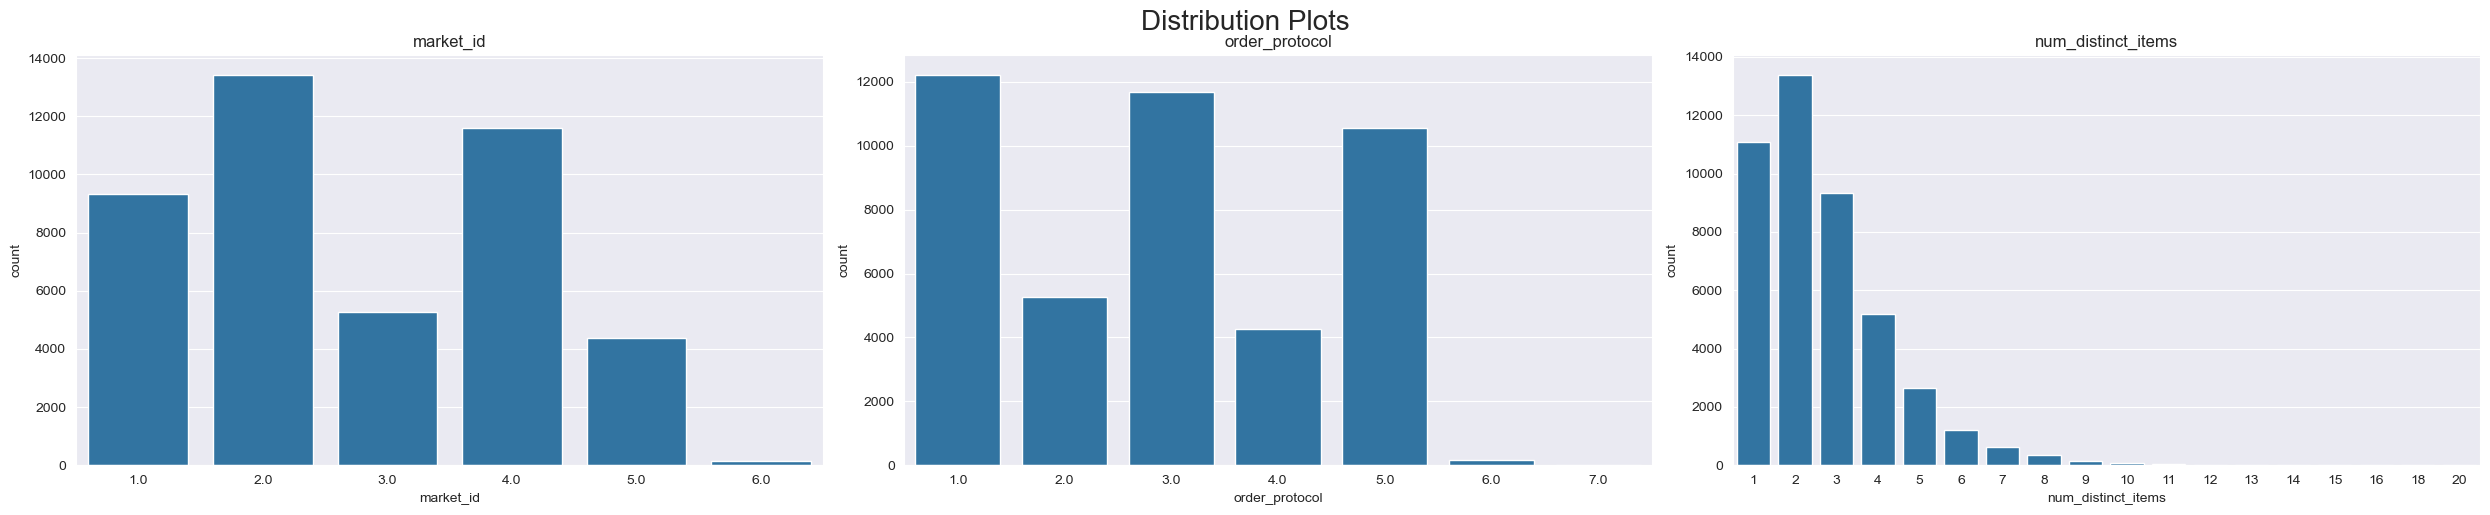

In [20]:
# Analyzing Categorical Columns

nrows = 1

fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(25, 5 * nrows))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Counter for axes fixing
counter = 0

# Loop through each continuous column to create distribution plots
for i, feature in enumerate(categorical_cols):
    if feature == 'store_id' or feature == 'store_primary_category': 
        counter += 1
        continue
    sns.countplot(data=pandas_df, x=feature, ax=axes[i-counter] )
    axes[i-counter].set_title(feature)

# Adjust layout
plt.tight_layout()

plt.suptitle("Distribution Plots", y=1.02, fontsize=20)
plt.show()

**Observe**
- Customers prefer to at least order two distinct items.

In [21]:
# Creating target variable for further analysis

from pyspark.sql.functions import col,round

df = df.withColumn("eta", round((col("actual_delivery_time").cast("long") - col("created_at").cast("long"))/60))
df.limit(3)

market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,eta
1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,63.0
2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,67.0
3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NULL,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,30.0


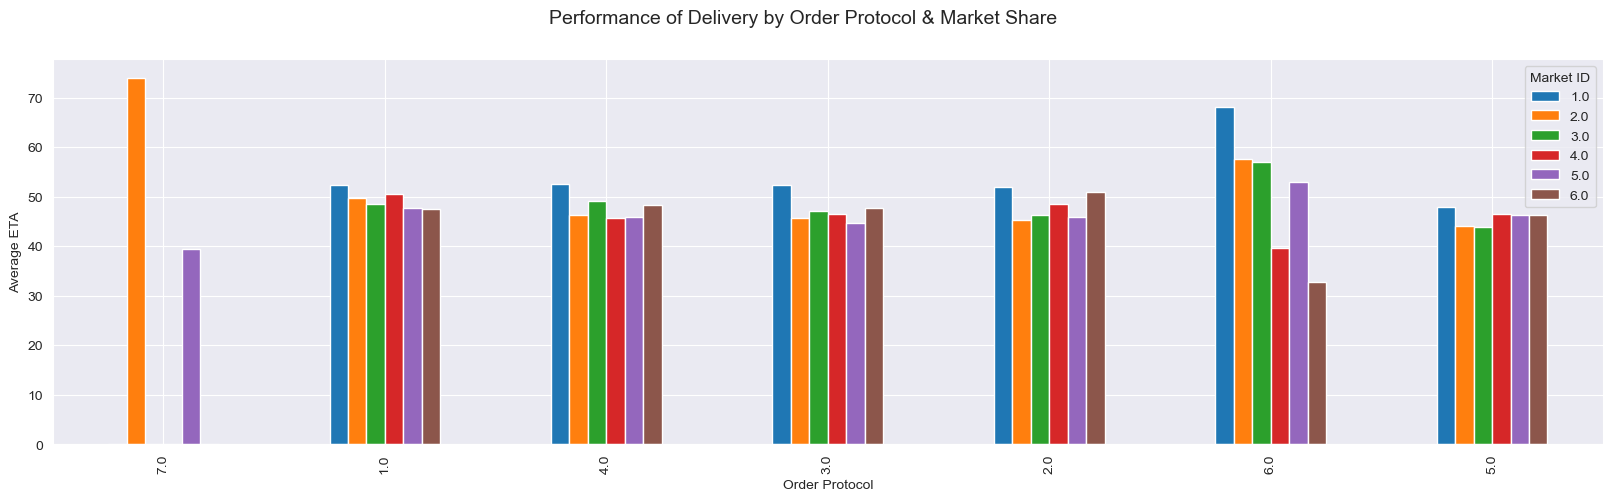

In [22]:
# ----Does the performance of delivery depends on order_protocol and market_id?----
from pyspark.sql.functions import avg

pandas_df = df.dropna()

grouped_df = pandas_df.groupby("order_protocol", "market_id").agg(avg("eta").alias("avg_eta"))
pivot_df = grouped_df.groupby("order_protocol").pivot("market_id").avg("avg_eta").fillna(0).toPandas().set_index("order_protocol")

pivot_df.plot(kind = "bar", stacked=False, figsize = (20,5))
plt.suptitle("Performance of Delivery by Order Protocol & Market Share", fontsize=14)
plt.xlabel('Order Protocol')
plt.ylabel('Average ETA')
plt.legend(title='Market ID')
plt.show()

**Observe**
- In Order Protocol 7, Not all market_id participates and order from market_id 2 takes most time to deliver.
- Order Protocol 6 is delivered fastest from market_id 6 and slowest from market_id 1

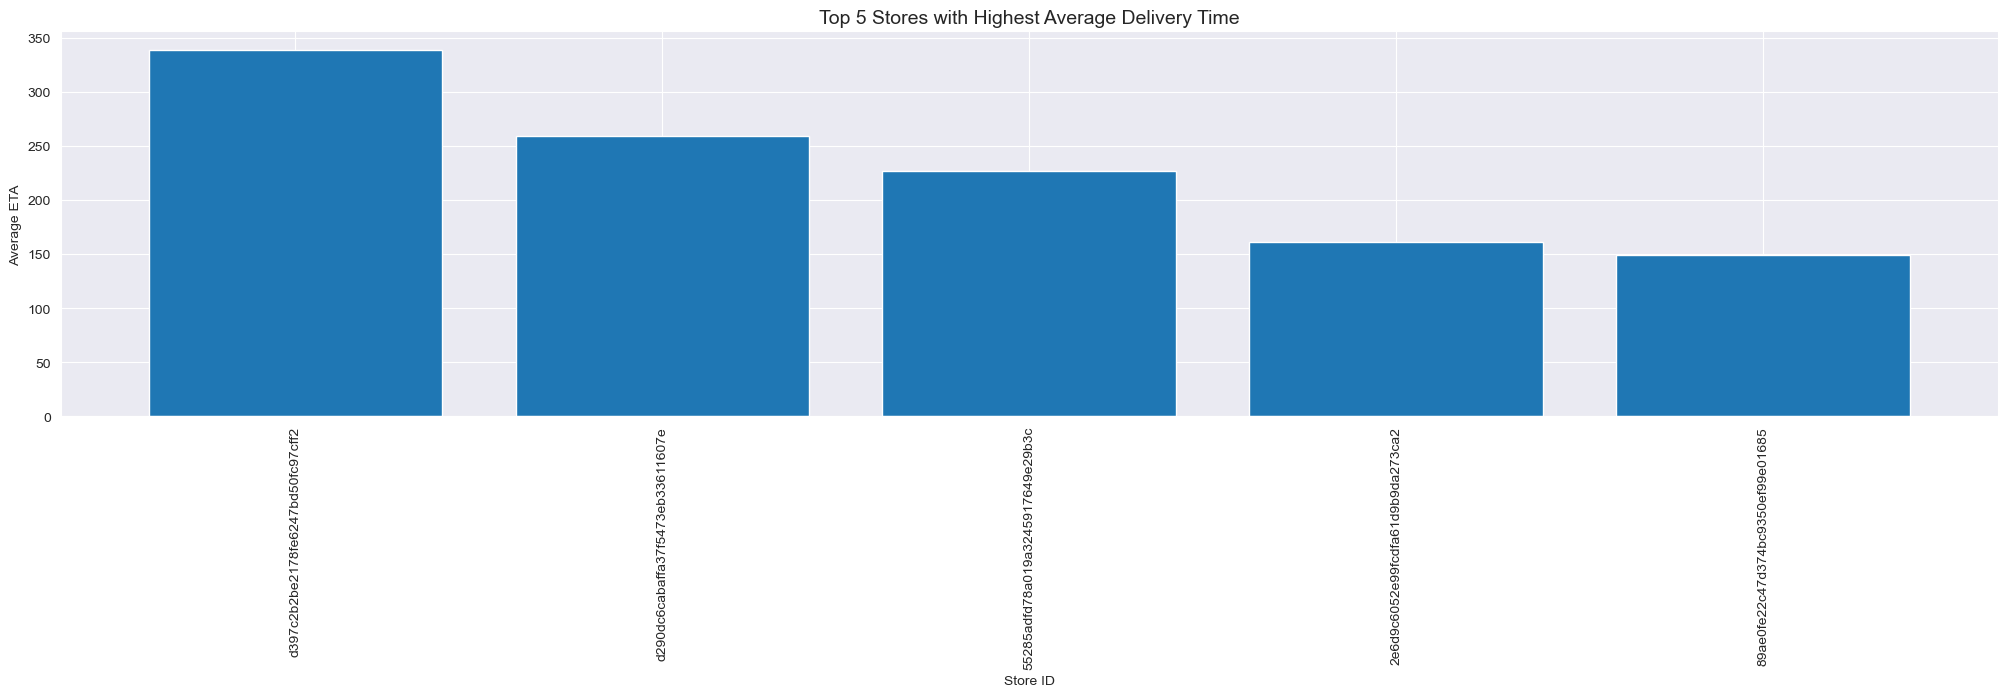

In [23]:
from pyspark.sql.functions import avg
import matplotlib.pyplot as plt

# Drop rows with null values
pandas_df = df.dropna()

# Group by store_id and calculate the average ETA
grouped_df = pandas_df.groupBy("store_id").agg(avg("eta").alias("avg_eta"))

# Convert the result to Pandas DataFrame for plotting
pandas_df = grouped_df.toPandas()

# Sort by average ETA and select the top 6
top_5_stores = pandas_df.sort_values(by='avg_eta', ascending=False).head(5)

# Plot the results
plt.figure(figsize=(25, 5))
plt.bar(top_5_stores['store_id'], top_5_stores['avg_eta'])
plt.title("Top 5 Stores with Highest Average Delivery Time", fontsize=14)
plt.xlabel('Store ID')
plt.ylabel('Average ETA')
plt.xticks(rotation=90)  # Rotate x-axis labels if necessary for better readability
plt.show()


**Observe**

- A very high `eta` of 300 minutes is observed for some stores.
- Needs further inspection.

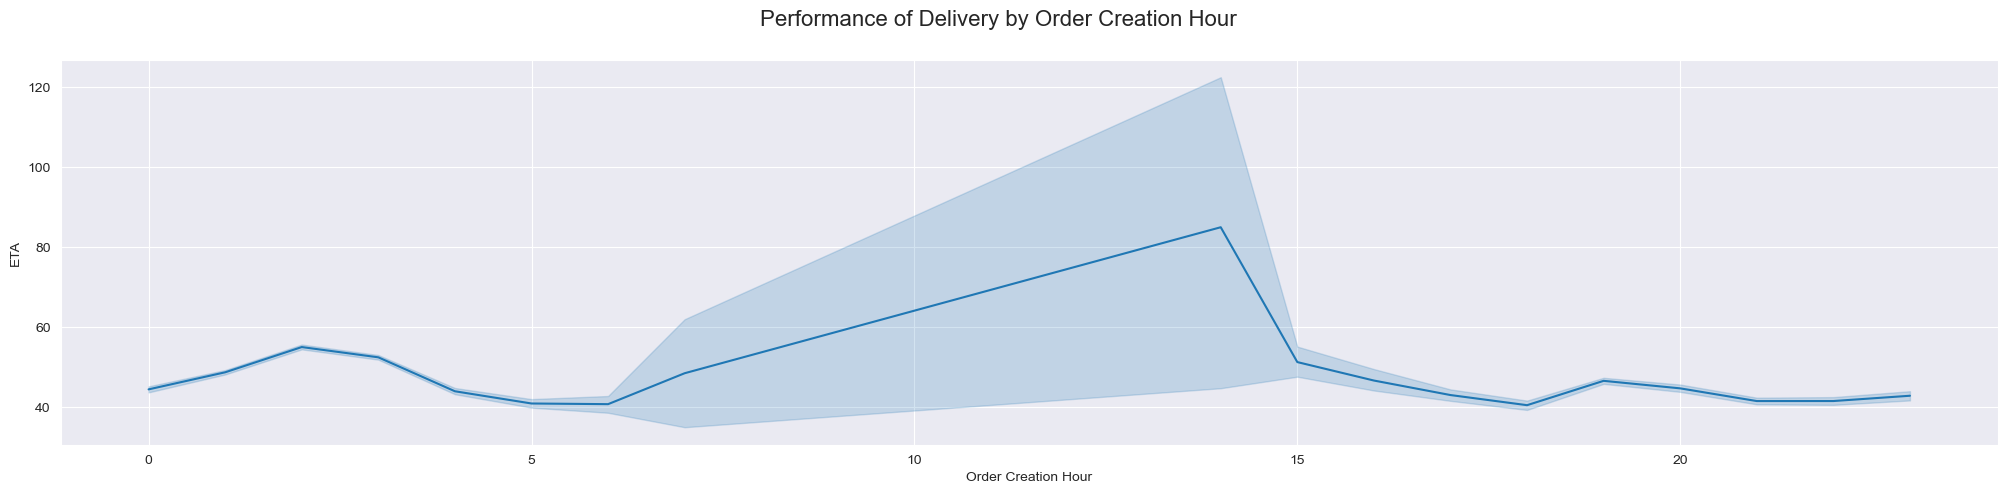

In [24]:
#----Effect of hour on ETA----

from pyspark.sql.functions import hour,col

# Extract hour column from created at
df = df.withColumn("hour", hour(col('created_at')))

pandas_df = df.dropna().sample(False,0.15,seed=42).toPandas()

plt.figure(figsize=(25,5))
sns.lineplot(x=pandas_df["hour"],y=pandas_df["eta"])
plt.suptitle("Performance of Delivery by Order Creation Hour", fontsize=16)
plt.xlabel('Order Creation Hour')
plt.ylabel('ETA')
plt.show()   

**Observe**
- Order takes more eta to deliver when it is placed during afternoon.

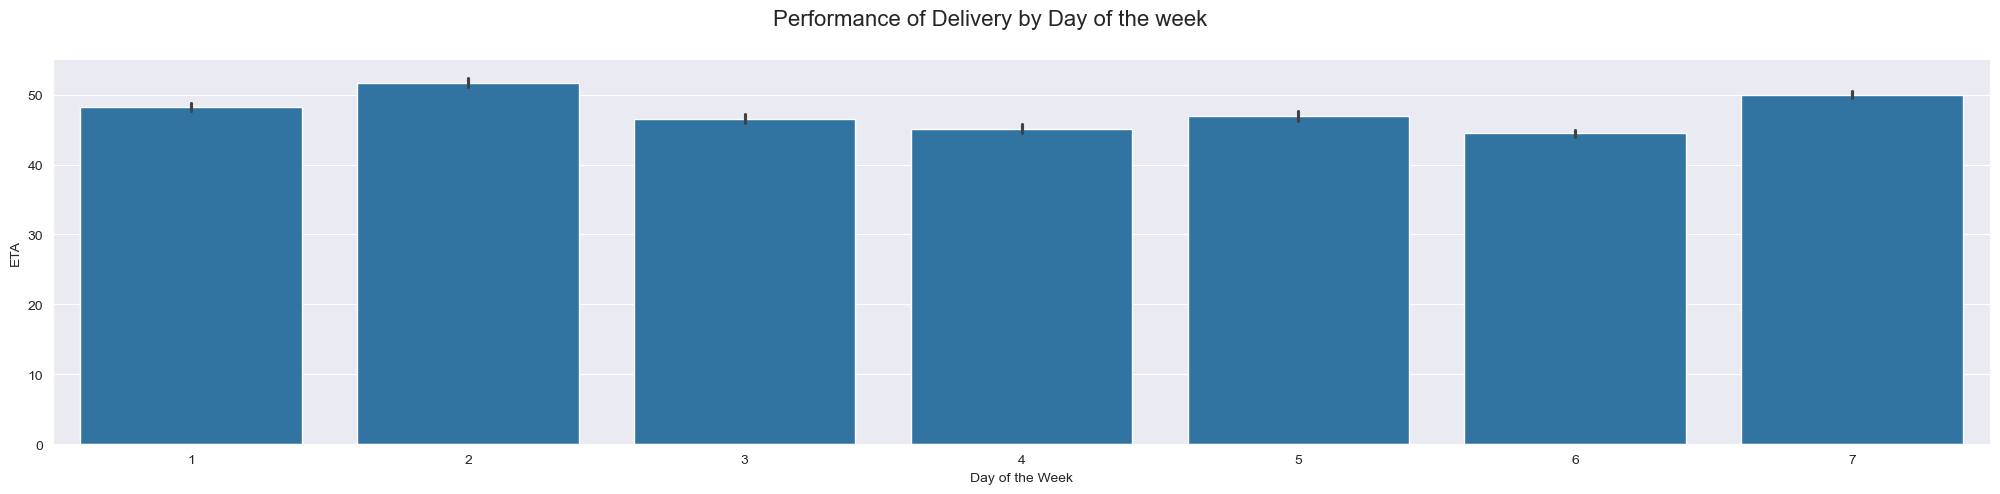

In [25]:
#----Effect of weekday on ETA----

from pyspark.sql.functions import dayofweek

# Extract hour column from created at
df = df.withColumn("day_of_week", dayofweek(col('created_at')))

pandas_df = df.dropna().sample(False,0.15,seed=42).toPandas()

plt.figure(figsize=(25,5))
sns.barplot(x=pandas_df["day_of_week"],y=pandas_df["eta"])
plt.suptitle("Performance of Delivery by Day of the week", fontsize=16)
plt.xlabel('Day of the Week')
plt.ylabel('ETA')
plt.show()   


In [26]:
# Appending New Feature to respective columns
categorical_cols.append('day_of_week')
categorical_cols.append('hour')
target_var = 'eta'

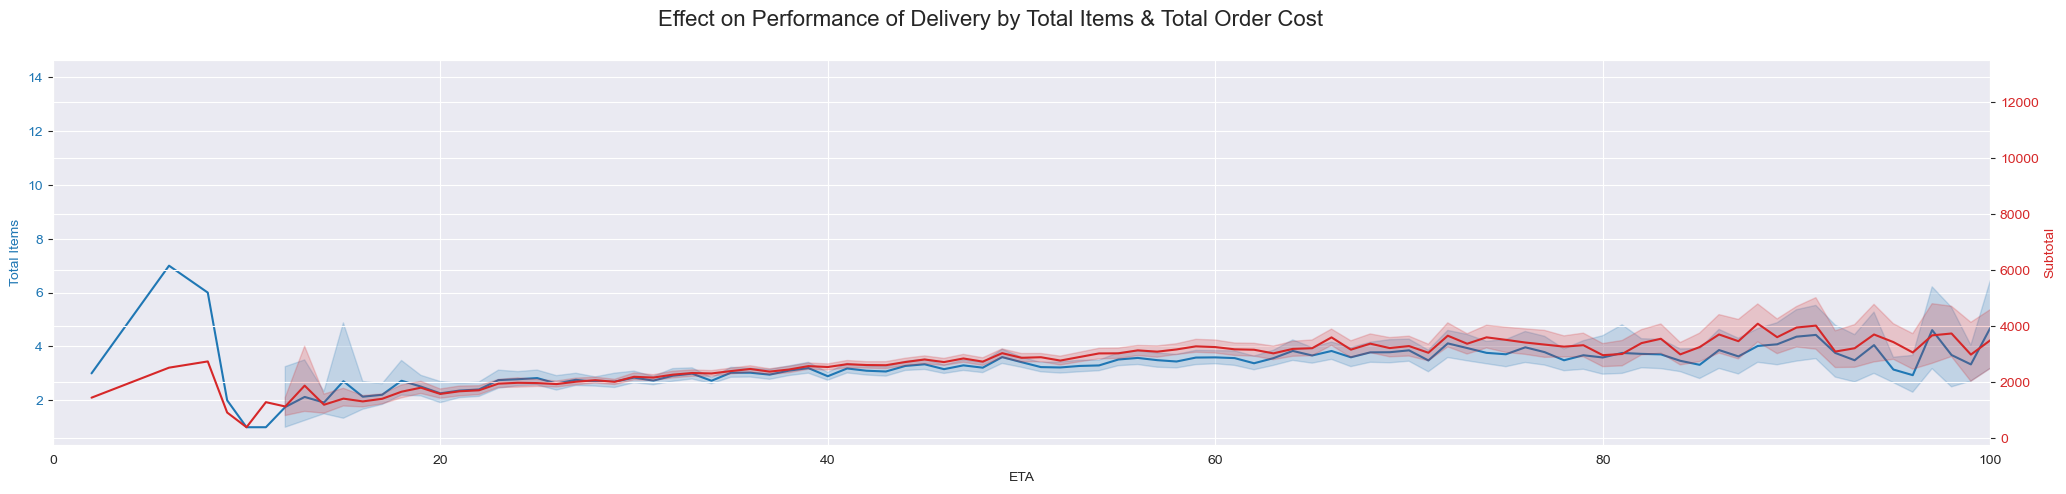

In [27]:
###----Effect on Performance of Delivery by Total Items & Total Order Cost---

fig, ax1 = plt.subplots(figsize=(25, 5))

# Plot total_items on the first y-axis
color = 'tab:blue'
ax1.set_xlabel('ETA')
ax1.set_ylabel('Total Items', color=color)
sns.lineplot(x=pandas_df["eta"], y=pandas_df["total_items"], ax=ax1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Subtotal', color=color)
sns.lineplot(x=pandas_df["eta"], y=pandas_df["subtotal"], ax=ax2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Add a title and show the plot
plt.suptitle("Effect on Performance of Delivery by Total Items & Total Order Cost", fontsize=16)
plt.xlim(0,100)
plt.show()

**Observe**
- No concrete visual pattern observed between Items Order Cost and eta.

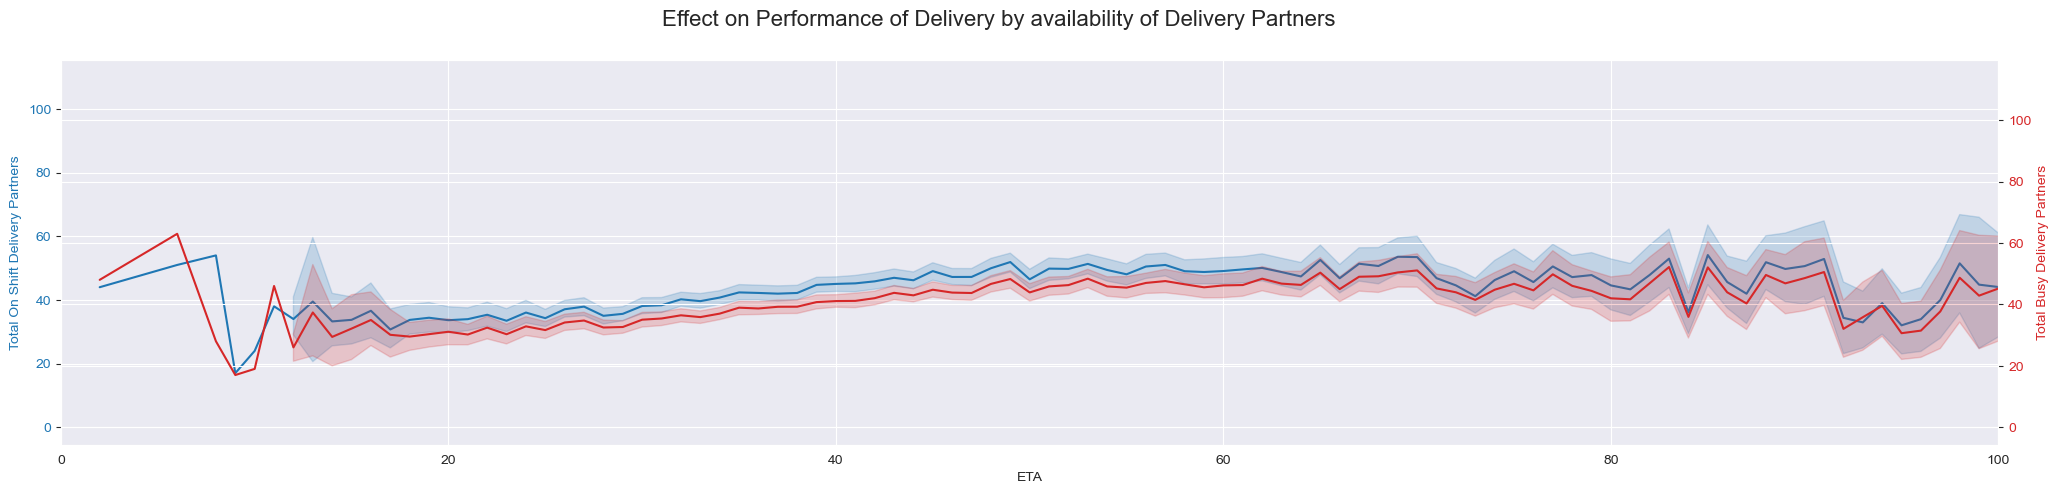

In [28]:
###----Analyze connection between total_onshift_partners 7 total_busy_partners w.r.t to eta---

###----Effect on Performance of Delivery by Total Items & Total Order Cost---

fig, ax1 = plt.subplots(figsize=(25, 5))

# Plot total_items on the first y-axis
color = 'tab:blue'
ax1.set_xlabel('ETA')
ax1.set_ylabel('Total On Shift Delivery Partners', color=color)
sns.lineplot(x=pandas_df["eta"], y=pandas_df["total_onshift_partners"], ax=ax1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Total Busy Delivery Partners', color=color)
sns.lineplot(x=pandas_df["eta"], y=pandas_df["total_busy_partners"], ax=ax2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Add a title and show the plot
plt.suptitle("Effect on Performance of Delivery by availability of Delivery Partners", fontsize=16)
plt.xlim(0,100)
plt.show()

**Observe**
- No concrete information could be gathered from the visuals.

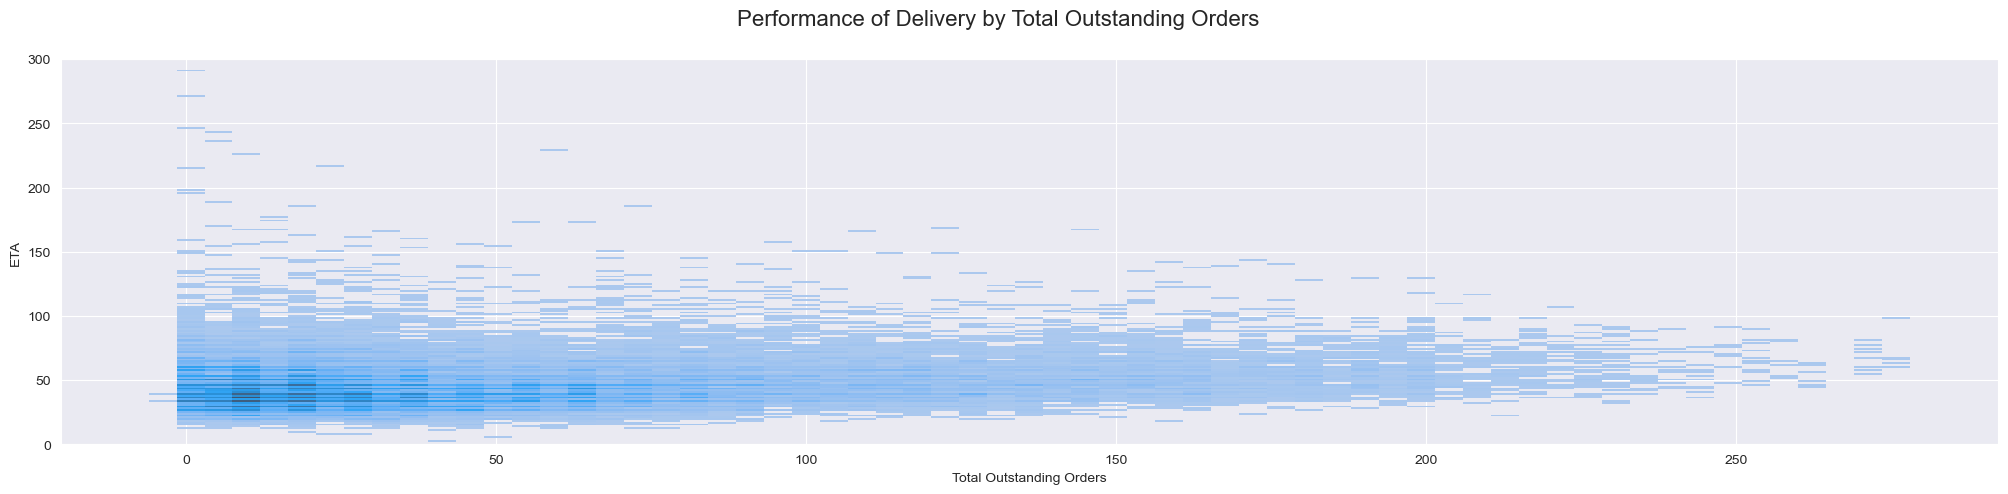

In [29]:
#---Total Outstanding Orders and Eta---
plt.figure(figsize=(25,5))
sns.histplot(data=pandas_df, x='total_outstanding_orders', y = 'eta')
plt.ylim(0,300)
plt.suptitle("Performance of Delivery by Total Outstanding Orders", fontsize=16)
plt.xlabel('Total Outstanding Orders')
plt.ylabel('ETA')
plt.show()  

**Observe**
- Slight pattern observed, where as the pending orders increase the eta also increases.

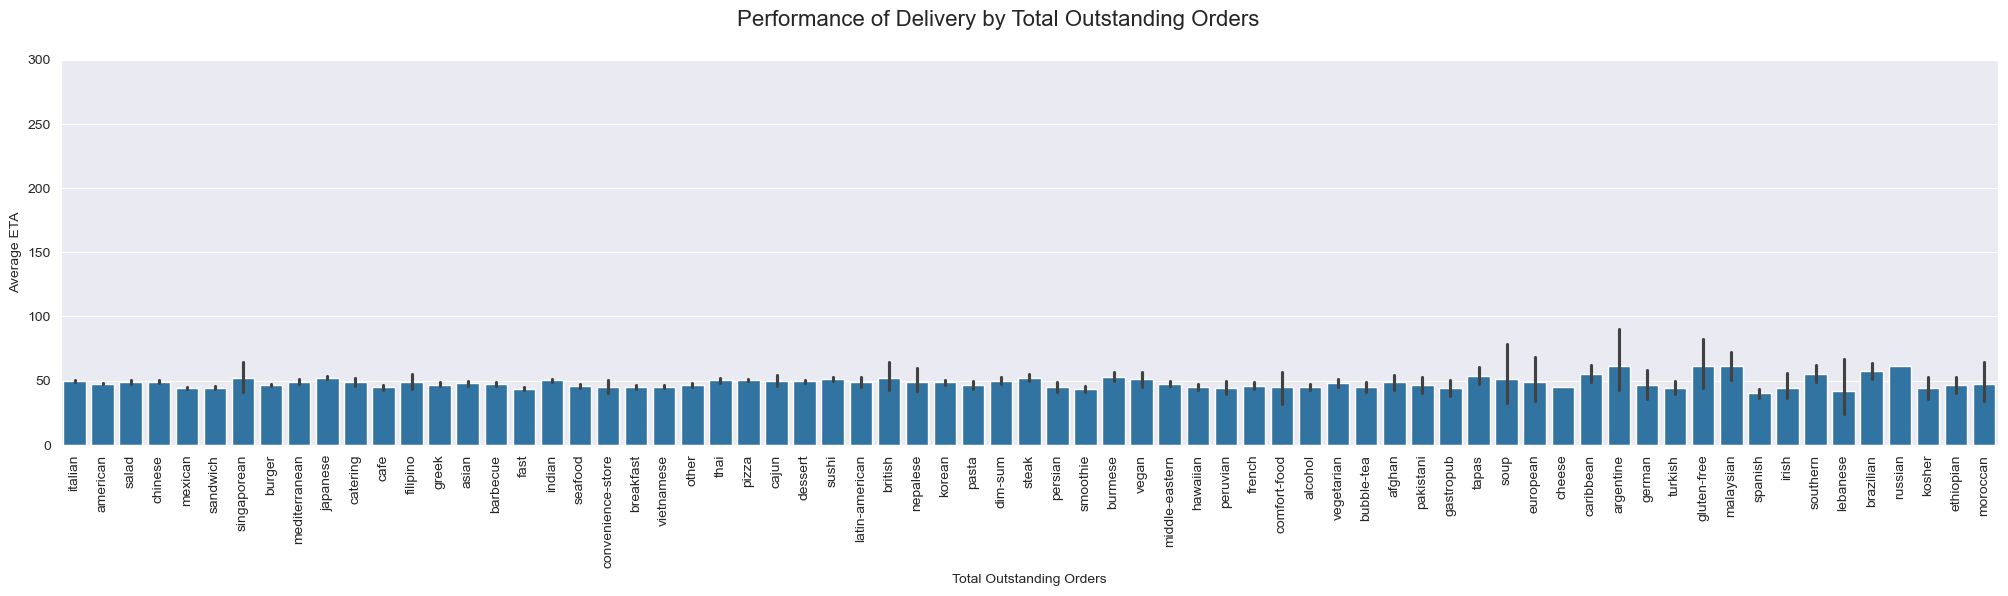

In [30]:
#---Analysis between ETA and Store Primary Category---
plt.figure(figsize=(25,5))
sns.barplot(data=pandas_df, x='store_primary_category', y = 'eta')
plt.ylim(0,300)
plt.suptitle("Performance of Delivery by Total Outstanding Orders", fontsize=16)
plt.xticks(rotation=90)
plt.xlabel('Total Outstanding Orders')
plt.ylabel('Average ETA')
plt.show()  

**Observe**
- Comfort Food generally takes more time to deliver.

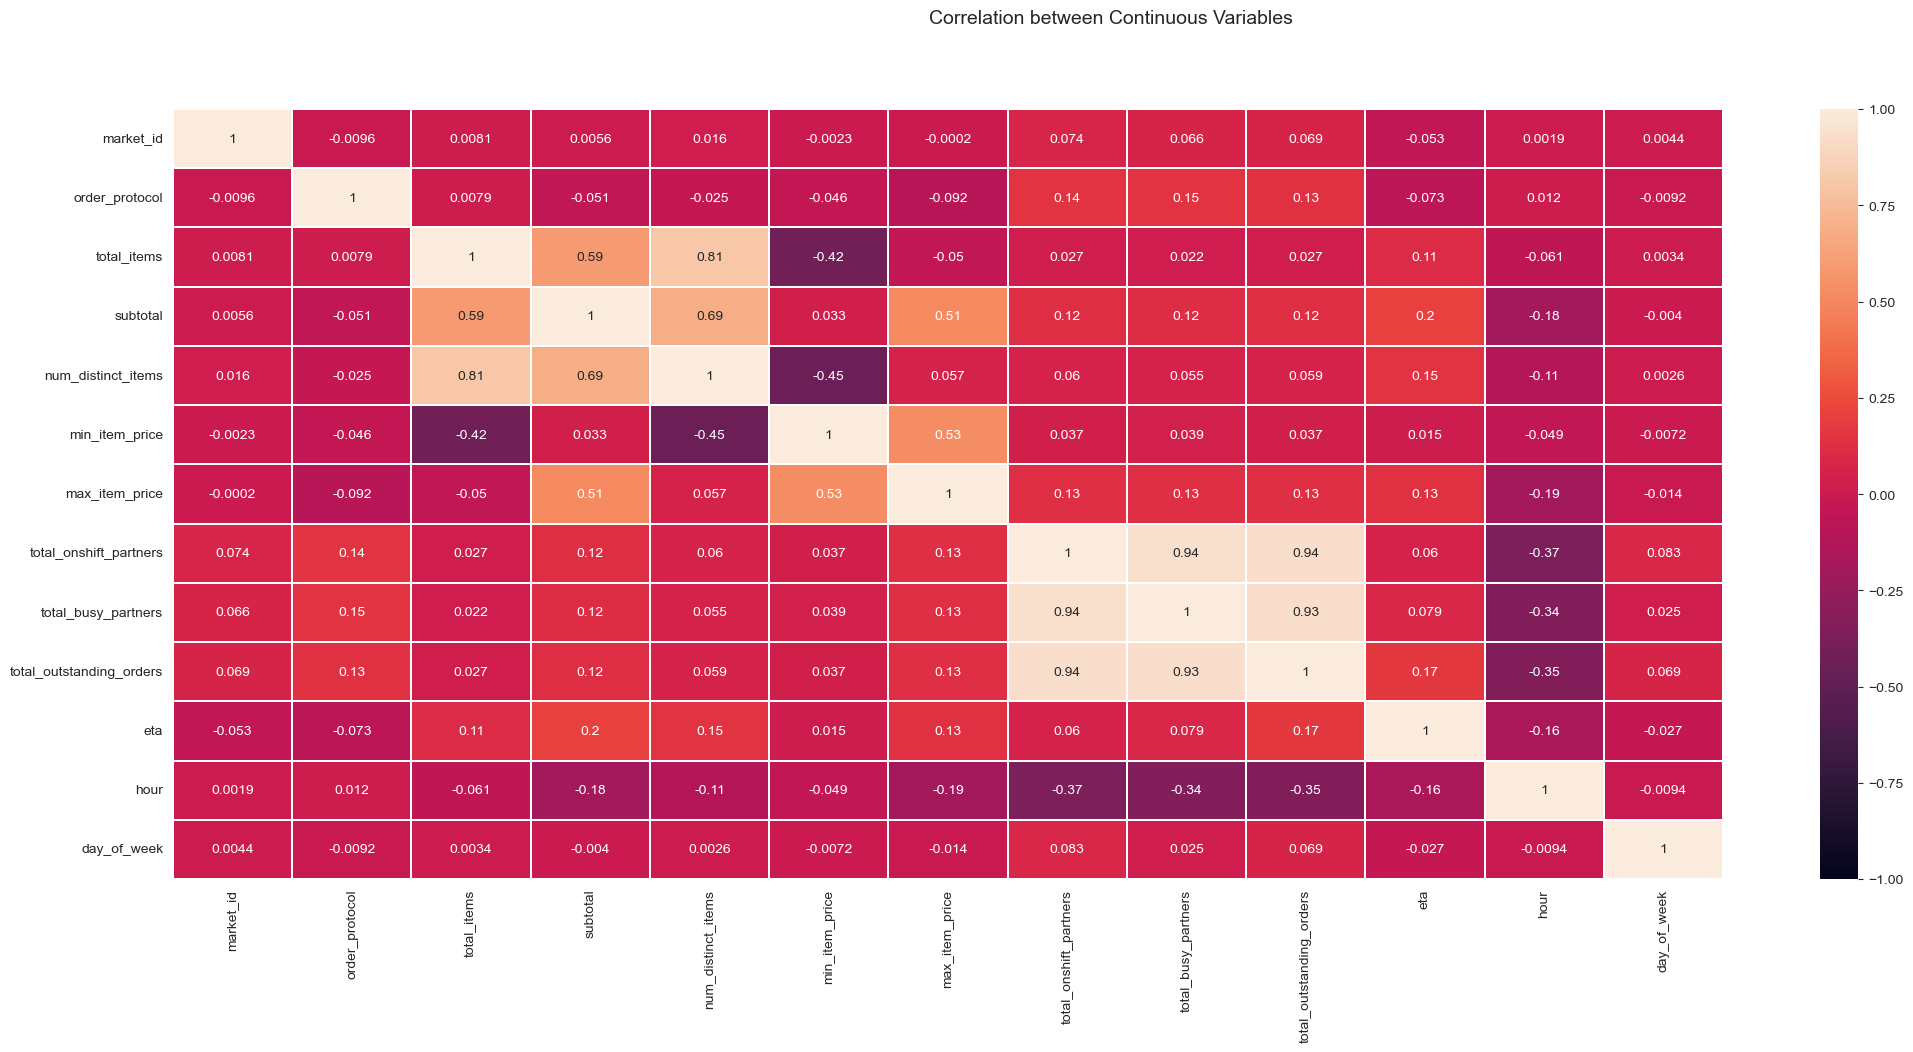

In [31]:
#---Verify Correlation Between Continuous Cols---
plt.figure(figsize=(25,10))
sns.heatmap(pandas_df.corr(numeric_only=True),annot=True,linewidths='0.01', vmin=-1,vmax=1)
plt.suptitle("Correlation between Continuous Variables", fontsize=14)
plt.show()  

**Observe**
- Total Items, Subtotal and Number of Distinct Items are Highly Correlated.
- Partners and Outstanding Orders also show Very High Correlation.
- Minimum Item Price shows negative Correlation with total_items and Num of Distinct Items.

In [32]:
#---Outlier Analysis---

import numpy as np

def iqr_outlier_detection(df, columns):
    bounds = {}
    for col_name in columns:
        quantiles = df.approxQuantile(col_name, [0.25, 0.75], 0.05)
        Q1, Q3 = quantiles[0], quantiles[1]
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        bounds[col_name] = (lower_bound, upper_bound)
    
    outlier_counts = {}
    total_counts = df.count()
    
    for col_name in columns:
        lower_bound, upper_bound = bounds[col_name]
        outliers = df.filter((col(col_name) < lower_bound) | (col(col_name) > upper_bound))
        
        outlier_count = outliers.count()
        outlier_percentage = np.round( (outlier_count / total_counts) * 100,2)
        
        outlier_counts[col_name] = outlier_percentage
    
    return outlier_counts

iqr_outlier_detection(df,continuous_cols)

{'total_items': 4.86,
 'subtotal': 5.84,
 'min_item_price': 3.25,
 'max_item_price': 4.77,
 'total_onshift_partners': 2.16,
 'total_busy_partners': 1.46,
 'total_outstanding_orders': 4.66}

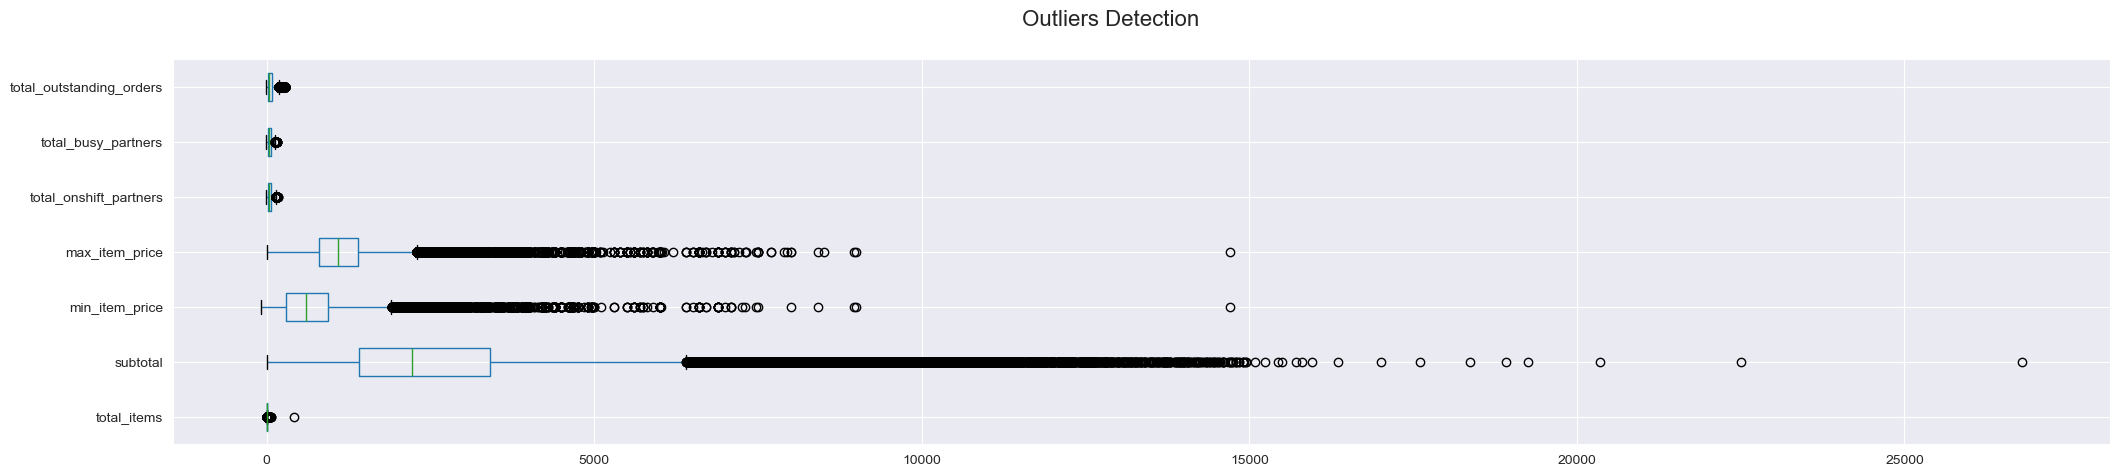

In [33]:
# Plotting Boxplot
df.select(*continuous_cols).dropna().toPandas().boxplot(vert=False,figsize=(25,5))
plt.suptitle("Outliers Detection", fontsize = 16)
plt.show()


**Observe**
- Outliers observed in total_items, max_item_price and subtotal most.

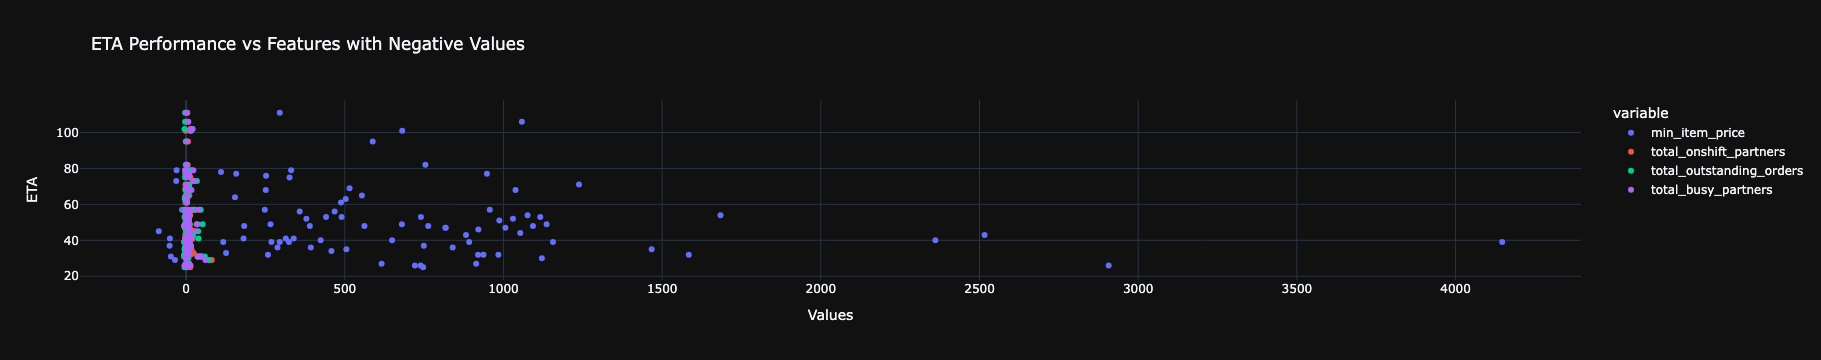

In [34]:
from pyspark.sql.functions import col
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "jupyterlab+png"

negative_cols = ['min_item_price','total_onshift_partners','total_outstanding_orders','total_busy_partners']
negative_pd_df = df.filter( (col('min_item_price')<0) | (col('total_onshift_partners')<0)  | (col('total_outstanding_orders')<0) 
          | (col('total_busy_partners')<0)  ).select(*negative_cols+['eta']).dropna().toPandas()

melted_df = negative_pd_df.melt(id_vars=['eta'], value_vars=negative_cols, var_name='variable', value_name='value')

fig = px.scatter(melted_df, x='value', y='eta',color='variable',title='ETA Performance vs Features with Negative Values')
fig.update_layout(xaxis_title='Values', yaxis_title='ETA')
fig.show()

**Observe**
- Negative Values could indicate, refund ore free product in min item price.
- Negative values in other could denote a state where delivery personals are available in excess or less indicating either. 

# Data Preprocessing

#### **Data Imputation**

In [35]:
# Dropping all those rows where we dont know actual delivery time.
df_filtered = df.dropna(subset=['actual_delivery_time'])
df_filtered.limit(5)

# Dropping where both market_id and store_primary_category is null
df_filtered = df_filtered.filter(~(df.market_id.isNull() & df.store_primary_category.isNull()))

In [36]:
# Imputing Store Primary Category with Mode of Market ID
from pyspark.sql import functions as F
from pyspark.sql.window import Window


df_filtered = df_filtered.fillna({"market_id": -1})

most_frequent_category = df_filtered.groupBy("market_id", "store_primary_category") \
    .count() \
    .withColumn("rank", F.row_number().over(Window.partitionBy("market_id").orderBy(F.desc("count")))) \
    .filter("rank = 1") \
    .select("market_id", "store_primary_category")

most_frequent_category = most_frequent_category.withColumnRenamed("store_primary_category", "most_frequent_category")
most_frequent_category.limit(5)

market_id,most_frequent_category
-1.0,american
1.0,american
2.0,mexican
3.0,american
4.0,pizza


In [37]:
df_filtered = df_filtered.join(most_frequent_category, on=["market_id"], how="left").withColumn(
    "store_primary_category",
    F.coalesce(df["store_primary_category"], most_frequent_category["most_frequent_category"])
).drop(most_frequent_category["most_frequent_category"])

df_filtered.limit(5)

market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,eta,hour,day_of_week
1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,63.0,22,6
2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,67.0,21,3
3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,american,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,30.0,20,5
3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,american,1.0,6,6900,5,600,1800,1.0,1.0,2.0,51.0,21,3
3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,american,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,40.0,2,1


In [38]:
df_filtered = df_filtered.withColumn("market_id", F.when(df_filtered["market_id"] == -1, None).otherwise(df_filtered["market_id"]))

In [39]:
# Imputing Continuous Columns

from sklearn.impute import KNNImputer

pandas_df = df_filtered.toPandas()

imputer = KNNImputer(n_neighbors=5)
imputed_array = imputer.fit_transform(pandas_df[continuous_cols +["market_id","order_protocol"]])    

# >>> could have also used Dask KNNImputer, since it supports parallelization

In [40]:
non_null_cat = [
    'store_id',
    'store_primary_category',
    'num_distinct_items',
    'day_of_week',
    'hour'
]

imputed_df = pd.DataFrame(imputed_array, columns=continuous_cols + ["market_id","order_protocol"])
concat_df = pd.concat([pandas_df[[target_var] + temporal_cols + non_null_cat], imputed_df], axis=1)

# Convert the imputed DataFrame back to Spark DataFrame
df_imputed = spark.createDataFrame(concat_df)

# Add an index column to original and imputed DataFrame to join them back
df.limit(5)

market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,eta,hour,day_of_week
1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,63.0,22,6
2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,67.0,21,3
3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NULL,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,30.0,20,5
3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NULL,1.0,6,6900,5,600,1800,1.0,1.0,2.0,51.0,21,3
3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NULL,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,40.0,2,1


In [41]:
# Verifying Total NaN's
concat_df.isna().sum()

eta                         0
created_at                  0
actual_delivery_time        0
store_id                    0
store_primary_category      0
num_distinct_items          0
day_of_week                 0
hour                        0
total_items                 0
subtotal                    0
min_item_price              0
max_item_price              0
total_onshift_partners      0
total_busy_partners         0
total_outstanding_orders    0
market_id                   0
order_protocol              0
dtype: int64

In [42]:
# Saving File
concat_df.to_csv("../data/clean/imputed.csv", index=False)

#### **Encoding Dataset**

In [43]:
df_imputed = spark.read.csv("../data/clean/imputed.csv", header=True, inferSchema=True)

**Explanation**
- Only need to encode `store_id` and `store_primary_category`
- For both we are going to use target encoding

In [44]:
# Target Encoding

# Calculate means with respect to the target
store_id_mean = df_imputed.groupBy('store_id').agg(F.mean(target_var).alias('store_id_mean_target'))
store_primary_category_mean = df_imputed.groupBy('store_primary_category').agg(F.mean(target_var).alias('store_primary_category_mean_target'))

df_imputed = df_imputed.join(store_id_mean, on='store_id', how='left')
df_imputed = df_imputed.join(store_primary_category_mean, on='store_primary_category', how='left')

# Replace original columns with the mean-encoded values
df_imputed = df_imputed.withColumnRenamed('store_id', 'original_store_id') \
                       .withColumnRenamed('store_primary_category', 'original_store_primary_category') \
                       .withColumnRenamed('store_id_mean_target', 'store_id') \
                       .withColumnRenamed('store_primary_category_mean_target', 'store_primary_category')


# Drop unwanted columns
columns_to_drop = ['actual_delivery_time', 'created_at', 'original_store_id', 'original_store_primary_category']
df_imputed = df_imputed.drop(*columns_to_drop)

#### **Handling Negative Values**

In [45]:
from pyspark.sql.functions import col

neg_cols= ['min_item_price', 'total_onshift_partners', 'total_outstanding_orders', 'total_busy_partners']
for column in neg_cols:
    df_imputed = df_imputed.filter(col(column) >= 0)

**Explanation**
- These values can be a typo or might be a scenario where it makes sense in business context. 
- For now, I am treating this as an anomaly and dropping rows with negative columns in these groups, the reason for this behaviour is because destructive in case of Log Transformation and Scaling as well.
- Moreover, Log Norm distributions can't have 0 or negative values.


#### **Handling Log Normal Disbs**

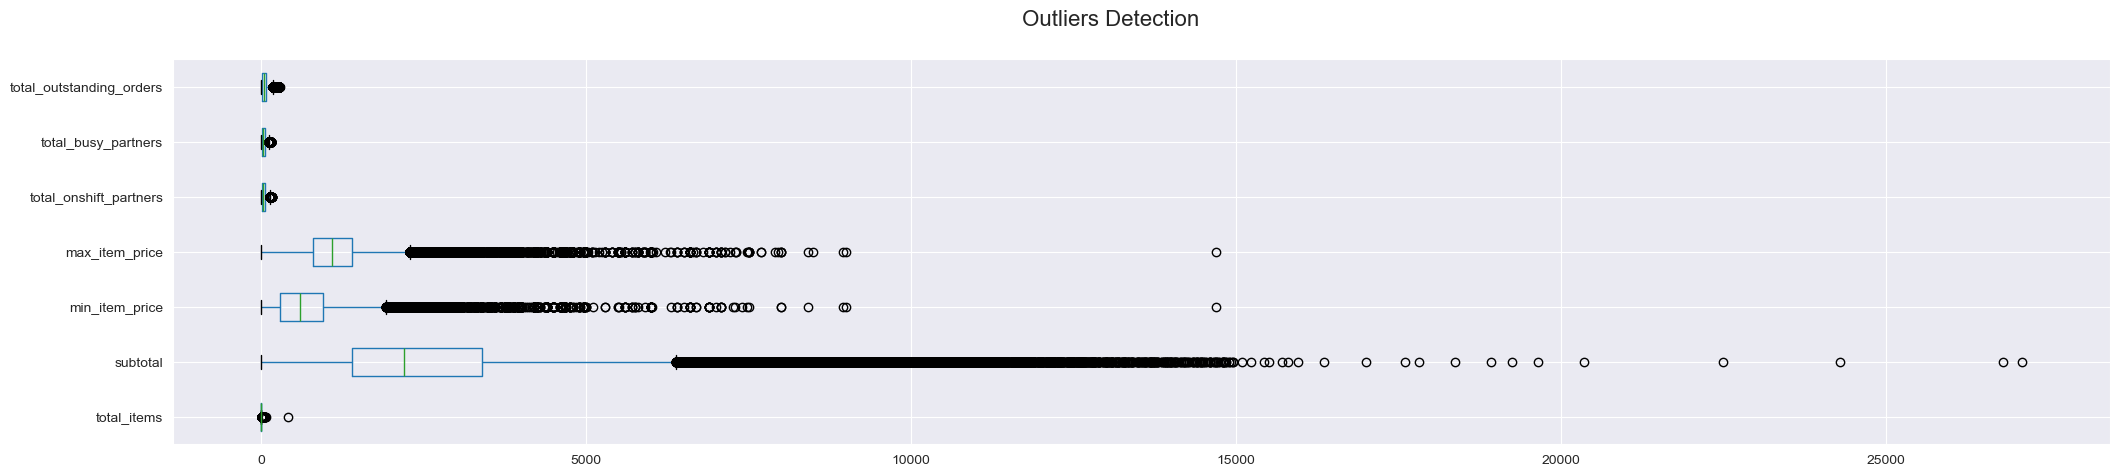

In [46]:
# Plotting Boxplot
df_imputed.select(*continuous_cols).dropna().toPandas().boxplot(vert=False,figsize=(25,5))
plt.suptitle("Outliers Detection", fontsize = 16)
plt.show()


In [47]:
# Reducing the affect of Outliers on log normal distributions
for col in continuous_cols:
        df_imputed = df_imputed.withColumn(col, F.log(F.col(col) + 1e-15))

**Explanation**
- A log normal value can never have negative values, so we are handling it by skipping apply log normal here.

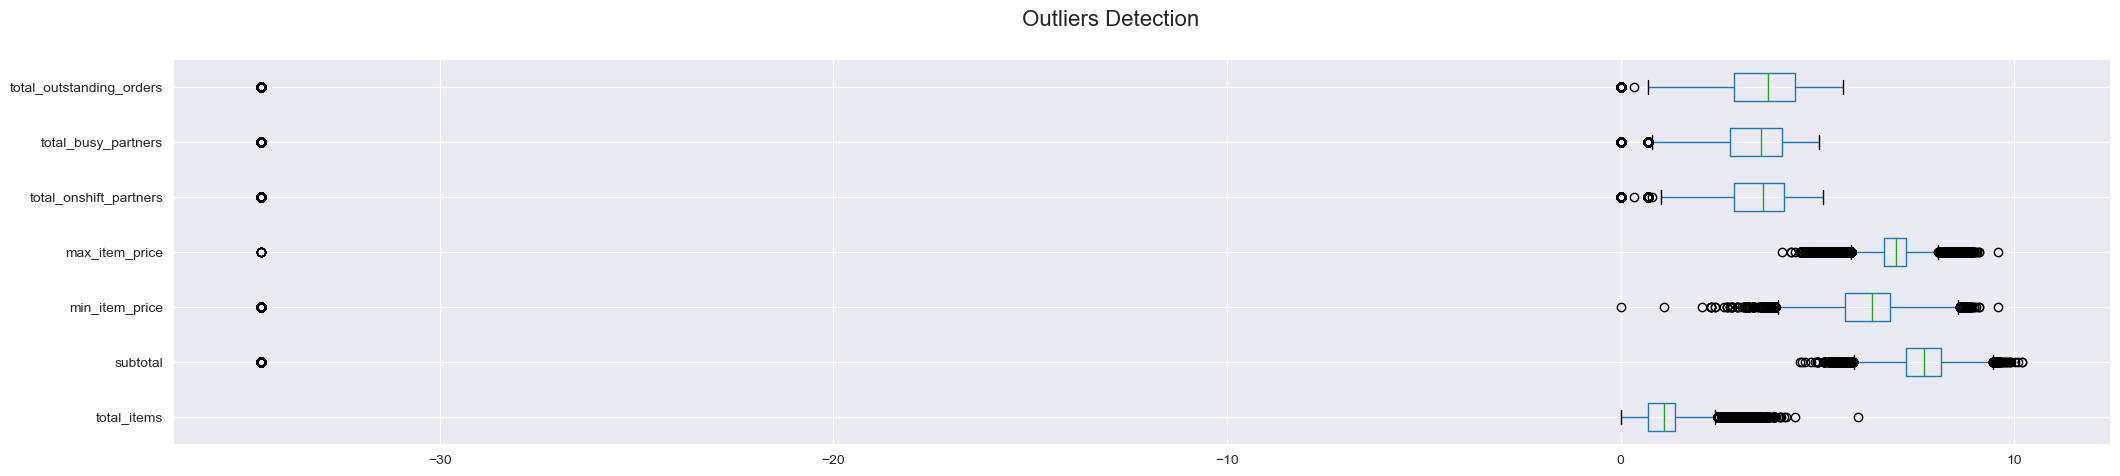

In [48]:
# Plotting Boxplot
df_imputed.select(*continuous_cols).dropna().toPandas().boxplot(vert=False,figsize=(25,5))
plt.suptitle("Outliers Detection", fontsize = 16)
plt.show()

In [49]:
df_imputed.toPandas().to_csv("../data/clean/encoded.csv", index=False)

#### **Outliers Detection using LOF**

In [54]:
df_encoded = pd.read_csv('../data/clean/encoded.csv')
df_encoded.head(5)

,eta,num_distinct_items,day_of_week,hour,total_items,subtotal,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,market_id,order_protocol,store_id,store_primary_category
0,63.0,4,6,22,1.386294e+00,8.143517,6.322565,7.122060,3.496508e+00,2.639057e+00,3.044522,1.0,1.0,63.000000,47.833310
1,67.0,1,3,21,1.110223e-15,7.549609,7.244228,7.244228,1.110223e-15,6.931472e-01,0.693147,2.0,2.0,48.076923,44.721816
2,30.0,1,5,20,1.110223e-15,7.549609,7.549609,7.549609,1.110223e-15,-3.453878e+01,-34.538776,3.0,1.0,48.076923,47.833310
3,51.0,5,3,21,1.791759e+00,8.839277,6.396930,7.495542,1.110223e-15,1.110223e-15,0.693147,3.0,1.0,48.076923,47.833310
4,40.0,3,1,2,1.098612e+00,8.268732,7.003065,7.377759,1.791759e+00,1.791759e+00,2.197225,3.0,1.0,48.076923,47.833310


In [55]:
# Splitting dataset
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_encoded, test_size=0.2, random_state=42) # train/test
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42) # train/val

In [52]:
# Standardizing and MinMax Scaling on test data
from sklearn.preprocessing import StandardScaler, MinMaxScaler

num_scaler = StandardScaler()
train_df[continuous_cols] = num_scaler.fit_transform(train_df[continuous_cols])

# MinMax Scaling categorical cols
cat_scaler = MinMaxScaler()
train_df[categorical_cols] = cat_scaler.fit_transform(train_df[categorical_cols])

# Scaling on Test & Validation Data
val_df[continuous_cols] = num_scaler.transform(val_df[continuous_cols])
val_df[categorical_cols] = cat_scaler.transform(val_df[categorical_cols])

test_df[continuous_cols] = num_scaler.transform(test_df[continuous_cols])
test_df[categorical_cols] = cat_scaler.transform(test_df[categorical_cols])

In [97]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05, novelty=True)  # Novelty for ability to detect anomalies in Test Data
lof_model = lof.fit(train_df.loc[:,train_df.columns != target_var].values)

**Explanation**
- We'll fit our lof model only on training set, so that our model generalizes instead of trying to learn noise. 

In [99]:
train_outliers = lof.predict(train_df.loc[:,train_df.columns != target_var].values)
val_outliers = lof.predict(val_df.loc[:,val_df.columns != target_var].values)
test_outliers = lof.predict(test_df.loc[:,test_df.columns != target_var].values)


assert len(train_outliers) == len(train_df)
assert len(val_outliers) == len(val_df)
assert len(test_outliers) == len(test_df)

In [100]:
total_outliers_train = sum(train_outliers == -1)
total_outliers_val = sum(val_outliers == -1)
total_outliers_test= sum(test_outliers == -1)

print(f"Train outliers detected: {total_outliers_train}")
print(f"Validation outliers detected: {total_outliers_val}")
print(f"Test outliers detected: {total_outliers_test}")


val_df = val_df[val_outliers == 1]
test_df = test_df[test_outliers == 1]
train_df = train_df[train_outliers == 1]

Train outliers detected: 3923
Validation outliers detected: 1536
Test outliers detected: 5074


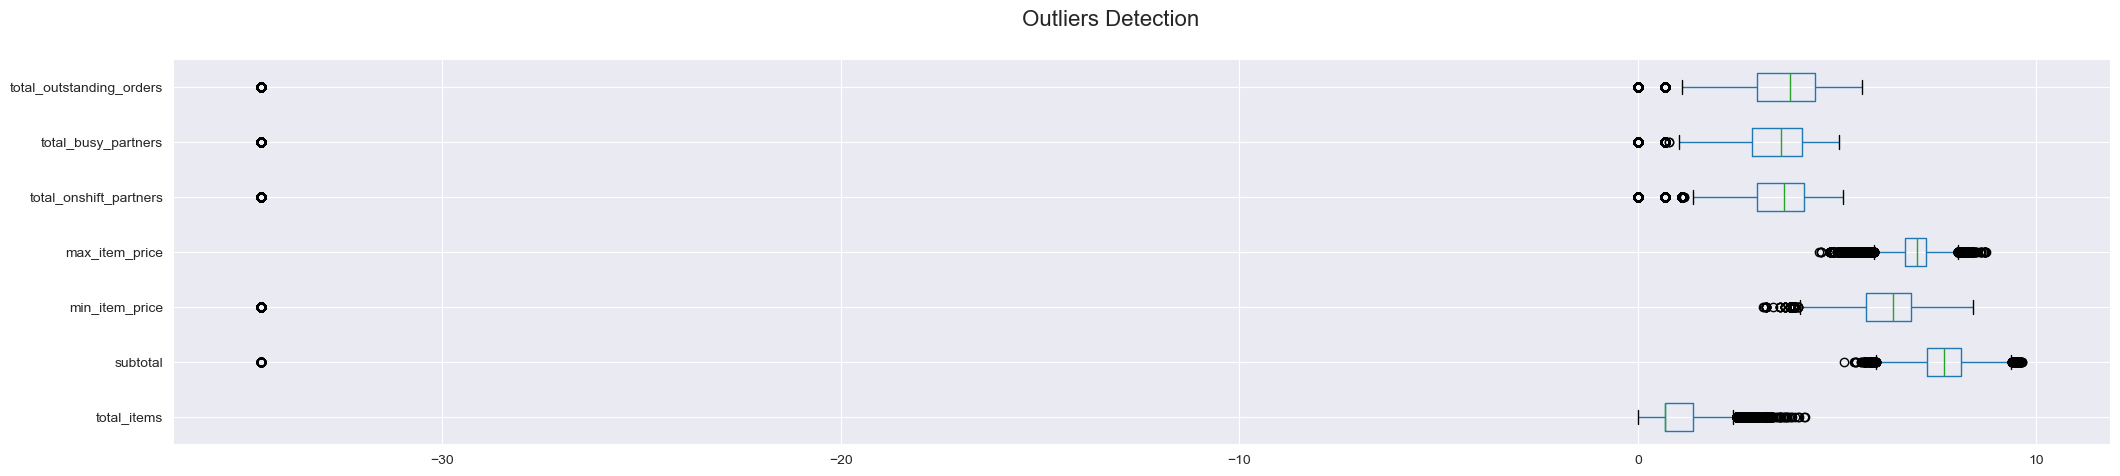

In [101]:
# Plotting Boxplot
train_df[continuous_cols].boxplot(vert=False,figsize=(25,5))
plt.suptitle("Outliers Detection", fontsize = 16)
plt.show()

**Observe**
- LOF works on High Dimensional, we cannot observe its effect properly here.

In [102]:
# Saving data
train_df.to_csv("../data/train/train.csv")
val_df.to_csv("../data/validation/val.csv")
test_df.to_csv("../data/test/test.csv")

# Data Modelling

#### **Simple Model**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split

train_df = pd.read_csv('../data/train/train.csv').drop(columns='Unnamed: 0')
val_df = pd.read_csv('../data/validation/val.csv').drop(columns='Unnamed: 0')
test_df = pd.read_csv('../data/test/test.csv').drop(columns='Unnamed: 0')

target_var = 'eta'

X_train = train_df.drop(target_var, axis=1)
y_train = train_df[target_var]
X_val = val_df.drop(target_var, axis=1)
y_val = val_df[target_var]
X_test = test_df.drop(target_var, axis=1)
y_test = test_df[target_var]

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Available Computation:",device)

Available Computation: cpu


In [ ]:
# Convert dataset for torch tensors since it support parallelization and much more

from torch.utils.data import DataLoader, TensorDataset

batch_size=512
train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Creating Simple Network of Neurons 

import torch
import torch.nn as nn

class SimpleNNModel(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNNModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32,1)
        )

    def forward(self, x):
        return self.model(x)
    
    # Kernel Initializer 
    def initialize_weights(self):
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                nn.init.constant_(layer.weight, 0)
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)

input_dim = X_train.shape[1]
model = SimpleNNModel(input_dim)

print(model)

In [ ]:
# Training the model

from torch.optim import Adam
from sklearn.metrics import mean_squared_error


# Training function
def train_model(model, train_loader, val_loader, epochs=10, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    train_loss = 0.0
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()   # Resets Gradient values to 0
            predictions = model(X_batch).squeeze() # Predict and matches output dimensions
            loss = criterion(predictions, y_batch) 
            loss.backward()
            optimizer.step()  # Update Weights
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                predictions = model(X_batch).squeeze()
                val_loss += criterion(predictions, y_batch).item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        if (epoch+1)%1 ==0:
            print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}')
        
    plt.figure(figsize=(25,5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Training and Validation Loss')
    plt.show()
        
    return model

In [ ]:
# Logging Simple Model

import mlflow
import mlflow.pytorch

mlflow.set_tracking_uri("../mlruns/")

mlflow.set_experiment("Simple NN")

with mlflow.start_run():
    model = train_model(model, train_loader, val_loader)
    mlflow.pytorch.log_model(model, "model")
    mlflow.log_param("epochs", 10)
    mlflow.log_param("learning_rate", 0.001),
    mlflow.log_param("batch_size", 512)

    
    # Evaluation on test set
    model.eval()
    with torch.no_grad():
        predictions = model(val_dataset[:][0]).squeeze()
        mse = mean_squared_error(val_dataset[:][1], predictions.numpy())
    
    mlflow.log_metric("test_loss", mse)
    print(f'Mean Squared Error on Validation Set: {mse}')

#### **Complex Model**

In [ ]:
# Convert dataset for torch tensors since it support parallelization and much more

from torch.utils.data import DataLoader, TensorDataset

batch_size=1024
train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Enhancing NN y
    # - Initializing Optimal Weights Kernel
    # - Adding batch normalisation
    # - Increasing epochs
    # - Adding more hidden layers
# Also we will log all of this under mlflowmlflow.set_experiment("Enhanced_Model_Experiment")

class EnhancedNNModel(nn.Module):
    def __init__(self, input_dim):
        super(EnhancedNNModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Linear activation for regression output
        )
        self.initialize_weights()

    def forward(self, x):
        return self.model(x)

    def initialize_weights(self):
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)
                    
input_dim = X_train.shape[1]
model = EnhancedNNModel(input_dim)

print(model)

In [65]:
# initializing Gradient Clipping as well

def train_model(model, train_loader, val_loader, epochs=50, learning_rate=0.0001):
    criterion = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for i, (X_batch, y_batch) in enumerate(train_loader):
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item()
                    
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                predictions = model(X_batch).squeeze()
                val_loss += criterion(predictions, y_batch).item()
        
        val_loss /= len(val_loader)
        if (epoch+1) % 10 == 0: 
            print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}')
        
    return model

In [66]:
# Log experiment with MLflow
mlflow.set_experiment("Enhanced NN")

with mlflow.start_run():
    mlflow.log_param("epochs", 100)
    mlflow.log_param("learning_rate", 0.0001)
    mlflow.log_param("batch_size", 1024)
    
    model = train_model(model, train_loader, val_loader, epochs = 50)
    
    # Log the model
    mlflow.pytorch.log_model(model, "model")
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        predictions = model(val_dataset[:][0]).squeeze()
        mse = mean_squared_error(val_dataset[:][1], predictions.numpy())
    
    mlflow.log_metric("test_loss", mse)
    print(f'Mean Squared Error on Validation Set: {mse}')

2024/06/19 17:38:46 INFO mlflow.tracking.fluent: Experiment with name 'Enhanced NN' does not exist. Creating a new experiment.


Epoch 10/50, Training Loss: 2184.286819893973, Validation Loss: 1872.4772216796875
Epoch 20/50, Training Loss: 1465.2214570545016, Validation Loss: 1143.5242379324777
Epoch 30/50, Training Loss: 849.2978907993862, Validation Loss: 551.9339381626675
Epoch 40/50, Training Loss: 582.0659673781622, Validation Loss: 310.36878356933596


2024/06/19 17:41:07 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch 50/50, Training Loss: 569.5548710414341, Validation Loss: 302.88875994001114


2024/06/19 17:41:11 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Mean Squared Error on Validation Set: 303.0518493652344


#### **Hyper Optimization using Hyperopt**

In [67]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defining Tensors for optimizing on Batch Size and moving to GPU
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

In [68]:
class EnhancedNNModel(nn.Module):
    def __init__(self, input_dim, bn_momentum=0.1, bn_eps=1e-5):
        super(EnhancedNNModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, momentum=bn_momentum, eps=bn_eps),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512, momentum=bn_momentum, eps=bn_eps),
            nn.ReLU(),
            nn.Linear(512, 1)  # Linear activation for regression output
        )
        self.initialize_weights()

    def forward(self, x):
        return self.model(x)

    def initialize_weights(self):
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)

In [69]:
from hyperopt import STATUS_OK


def train_model(params):
    # Unpack parameters
    batch_size = int(params['batch_size'])
    learning_rate = params['learning_rate']
    epochs = int(params['epochs'])
    bn_momentum = params['bn_momentum']
    bn_eps = params['bn_eps']
    betas = (params['beta1'], params['beta2'])
    weight_decay = params['weight_decay']
    
    # Prepare data loaders with the given batch size
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
    
    # Initialize model
    input_dim = X_train.shape[1]
    model = EnhancedNNModel(input_dim, bn_momentum=bn_momentum, bn_eps=bn_eps).to(device)
    
    criterion = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate, betas=betas, weight_decay=weight_decay)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for i, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move to GPU
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move to GPU
                predictions = model(X_batch).squeeze()
                val_loss += criterion(predictions, y_batch).item()
        
        val_loss /= len(val_loader)
        if (epoch+1) % 10 == 0: 
            print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}')
        
    # Evaluate on the validation set
    model.eval()
    with torch.no_grad():
        predictions = model(X_val_tensor).squeeze()
        val_loss = mean_squared_error(y_val_tensor.cpu().numpy(), predictions.cpu().numpy())
    
    return {'loss': val_loss, 'status': STATUS_OK, 'model': model}

In [70]:
from hyperopt import fmin, tpe, hp, Trials

# Set the experiment name
mlflow.set_experiment("Model HyperParam Optimization")

# Hyperparameter optimization space
space = {
    'batch_size': hp.quniform('batch_size', 32, 128, 32),
    'learning_rate': hp.loguniform('learning_rate', -5, -1),
    'epochs': 25,
    'bn_momentum': hp.uniform('bn_momentum', 0.01, 0.99),
    'bn_eps': hp.loguniform('bn_eps', -8, -1),
    'beta1': hp.uniform('beta1', 0.5, 0.9),
    'beta2': hp.uniform('beta2', 0.9, 0.999),
    'weight_decay': hp.loguniform('weight_decay', -10, -1)
}

# Objective function for Hyperopt
def objective(params):
    with mlflow.start_run(nested=True):
        mlflow.log_params(params)
        result = train_model(params)
        mlflow.log_metric('val_loss', result['loss'])
        mlflow.pytorch.log_model(result['model'], 'model')
        return result

# Run Hyperopt optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=25, trials=trials)

print("Best parameters found: ", best)

2024/06/19 17:41:12 INFO mlflow.tracking.fluent: Experiment with name 'Model HyperParam Optimization' does not exist. Creating a new experiment.


Epoch 10/25, Training Loss: 628.381026741124, Validation Loss: 655.3015632354956
Epoch 20/25, Training Loss: 627.9815303937504, Validation Loss: 352.9406011842138
  0%|          | 0/25 [02:07<?, ?trial/s, best loss=?]

2024/06/19 17:43:52 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2024/06/19 17:43:56 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Epoch 10/25, Training Loss: 663.4239703580586, Validation Loss: 407.9924636676157  
Epoch 20/25, Training Loss: 664.994623887875, Validation Loss: 404.31840293527506  
  4%|▍         | 1/25 [06:33<1:05:37, 164.07s/trial, best loss: 1782.9268798828125]

2024/06/19 17:48:43 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2024/06/19 17:48:47 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Epoch 10/25, Training Loss: 665.1009610951376, Validation Loss: 1780.0027054532197 
Epoch 20/25, Training Loss: 665.1206884589984, Validation Loss: 559.9330868785272 
  8%|▊         | 2/25 [09:06<1:31:32, 238.82s/trial, best loss: 425.8787841796875]

2024/06/19 17:50:41 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2024/06/19 17:50:46 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Epoch 10/25, Training Loss: 586.5670646100307, Validation Loss: 313.7337314413606 
Epoch 20/25, Training Loss: 585.9072638678608, Validation Loss: 306.57745679676964
 12%|█▏        | 3/25 [10:47<1:07:25, 183.89s/trial, best loss: 412.7989807128906]

2024/06/19 17:52:18 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2024/06/19 17:52:22 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Epoch 10/25, Training Loss: 690.0097689293929, Validation Loss: 434.9957563825648 
Epoch 20/25, Training Loss: 688.2947519138751, Validation Loss: 859.4375913880712
 16%|█▌        | 4/25 [13:19<52:18, 149.46s/trial, best loss: 305.62469482421875]

2024/06/19 17:55:04 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2024/06/19 17:55:08 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Epoch 10/25, Training Loss: 642.3413747151693, Validation Loss: 388.2312951945572
Epoch 20/25, Training Loss: 643.7941462381852, Validation Loss: 429.11685630743455
 20%|██        | 5/25 [15:11<51:49, 155.49s/trial, best loss: 305.62469482421875]

2024/06/19 17:56:42 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2024/06/19 17:56:46 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Epoch 10/25, Training Loss: 595.6782028280574, Validation Loss: 340.31150970047696
Epoch 20/25, Training Loss: 595.3447999130908, Validation Loss: 317.0171821779318
 24%|██▍       | 6/25 [17:06<43:01, 135.89s/trial, best loss: 305.62469482421875]

2024/06/19 17:58:41 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2024/06/19 17:58:45 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Epoch 10/25, Training Loss: 590.8444482658034, Validation Loss: 307.9506414262511
Epoch 20/25, Training Loss: 589.2943145761107, Validation Loss: 306.3328827096404
 28%|██▊       | 7/25 [19:40<39:07, 130.42s/trial, best loss: 305.62469482421875]

2024/06/19 18:01:24 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2024/06/19 18:01:28 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Epoch 10/25, Training Loss: 595.6704510858692, Validation Loss: 314.10835692865385
Epoch 20/25, Training Loss: 594.3986302898112, Validation Loss: 313.0560833910386
 32%|███▏      | 8/25 [22:22<39:52, 140.73s/trial, best loss: 305.62469482421875]

2024/06/19 18:04:06 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2024/06/19 18:04:10 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Epoch 10/25, Training Loss: 587.0174315678987, Validation Loss: 307.1245302267152
Epoch 20/25, Training Loss: 586.3415019769462, Validation Loss: 306.2758468052126
 36%|███▌      | 9/25 [24:30<39:18, 147.38s/trial, best loss: 305.62469482421875]

2024/06/19 18:06:06 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2024/06/19 18:06:10 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Epoch 10/25, Training Loss: 583.0731016180797, Validation Loss: 302.30200753795157
Epoch 20/25, Training Loss: 581.4027747398518, Validation Loss: 301.7011179340829 
 40%|████      | 10/25 [27:03<34:42, 138.85s/trial, best loss: 305.62469482421875]

2024/06/19 18:08:47 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2024/06/19 18:08:51 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Epoch 10/25, Training Loss: 589.552764238107, Validation Loss: 328.94323779867705 
Epoch 20/25, Training Loss: 589.583864153683, Validation Loss: 306.77590021641134 
 44%|████▍     | 11/25 [29:44<33:58, 145.61s/trial, best loss: 301.82501220703125]

2024/06/19 18:11:28 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2024/06/19 18:11:32 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Epoch 10/25, Training Loss: 601.586748507383, Validation Loss: 367.99409859135466 
Epoch 20/25, Training Loss: 603.2533011539377, Validation Loss: 453.16981366509697
 48%|████▊     | 12/25 [31:51<32:33, 150.25s/trial, best loss: 301.82501220703125]

2024/06/19 18:13:26 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2024/06/19 18:13:30 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Epoch 10/25, Training Loss: 2350.8068725805488, Validation Loss: 2068.1670925418002
Epoch 20/25, Training Loss: 2351.0197380669683, Validation Loss: 2068.750987091476
 52%|█████▏    | 13/25 [33:50<28:08, 140.69s/trial, best loss: 301.82501220703125]

2024/06/19 18:15:25 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2024/06/19 18:15:29 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Epoch 10/25, Training Loss: 988.297693592385, Validation Loss: 707.6013095773382  
Epoch 20/25, Training Loss: 988.3794357492027, Validation Loss: 707.6145843396084 
 56%|█████▌    | 14/25 [38:05<24:34, 134.05s/trial, best loss: 301.82501220703125]

2024/06/19 18:20:14 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2024/06/19 18:20:18 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Epoch 10/25, Training Loss: 585.4620402562532, Validation Loss: 309.162523912291  
Epoch 20/25, Training Loss: 584.425268324159, Validation Loss: 305.5881029113605  
 60%|██████    | 15/25 [40:38<30:07, 180.76s/trial, best loss: 301.82501220703125]

2024/06/19 18:22:13 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2024/06/19 18:22:17 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Epoch 10/25, Training Loss: 589.6581678922547, Validation Loss: 310.8262493970583 
Epoch 20/25, Training Loss: 588.050190765985, Validation Loss: 317.64066173361357 
 64%|██████▍   | 16/25 [44:53<24:18, 162.08s/trial, best loss: 301.82501220703125]

2024/06/19 18:27:02 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2024/06/19 18:27:06 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Epoch 10/25, Training Loss: 593.1449033819514, Validation Loss: 320.2572547727518 
Epoch 20/25, Training Loss: 592.4947123561832, Validation Loss: 317.7040654102747 
 68%|██████▊   | 17/25 [47:25<26:42, 200.35s/trial, best loss: 301.82501220703125]

2024/06/19 18:29:00 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2024/06/19 18:29:05 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Epoch 10/25, Training Loss: 588.7672648441305, Validation Loss: 310.6553981973113 
Epoch 20/25, Training Loss: 587.8899277794561, Validation Loss: 313.71589018458087
 72%|███████▏  | 18/25 [49:08<20:30, 175.74s/trial, best loss: 301.82501220703125]

2024/06/19 18:30:40 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2024/06/19 18:30:44 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Epoch 10/25, Training Loss: 1820.0736811429763, Validation Loss: 1538.6344644011353
Epoch 20/25, Training Loss: 1820.069579492656, Validation Loss: 1538.6839243936881
 76%|███████▌  | 19/25 [50:46<15:16, 152.80s/trial, best loss: 301.82501220703125]

2024/06/19 18:32:17 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2024/06/19 18:32:21 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Epoch 10/25, Training Loss: 609.3982478177826, Validation Loss: 341.9722344583745 
Epoch 20/25, Training Loss: 608.8186859240701, Validation Loss: 322.1571801137581 
 80%|████████  | 20/25 [54:56<11:20, 136.00s/trial, best loss: 301.82501220703125]

2024/06/19 18:37:06 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2024/06/19 18:37:10 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Epoch 10/25, Training Loss: 582.2457859288738, Validation Loss: 302.3037818112819 
Epoch 20/25, Training Loss: 581.2912387676273, Validation Loss: 301.8621577530456 
 84%|████████▍ | 21/25 [58:07<12:08, 182.05s/trial, best loss: 301.82501220703125]

2024/06/19 18:39:51 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2024/06/19 18:39:55 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Epoch 10/25, Training Loss: 581.974894729001, Validation Loss: 302.5213943591221  
Epoch 20/25, Training Loss: 581.0967699312921, Validation Loss: 305.82879823917966
 88%|████████▊ | 22/25 [1:00:50<08:50, 176.84s/trial, best loss: 301.82501220703125]

2024/06/19 18:42:34 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2024/06/19 18:42:39 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Epoch 10/25, Training Loss: 592.1285549957879, Validation Loss: 325.8851873960426   
Epoch 20/25, Training Loss: 591.9431736882603, Validation Loss: 322.5080038249064   
 92%|█████████▏| 23/25 [1:03:34<05:45, 172.88s/trial, best loss: 301.29644775390625]

2024/06/19 18:45:18 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2024/06/19 18:45:22 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



Epoch 10/25, Training Loss: 593.8140311215406, Validation Loss: 320.2689126103902   
Epoch 20/25, Training Loss: 593.8442033768845, Validation Loss: 380.0588903221295   
 96%|█████████▌| 24/25 [1:08:03<02:50, 170.15s/trial, best loss: 301.29644775390625]

2024/06/19 18:50:13 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.

2024/06/19 18:50:17 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



100%|██████████| 25/25 [1:09:05<00:00, 165.83s/trial, best loss: 301.29644775390625]
Best parameters found:  {'batch_size': 64.0, 'beta1': 0.5004676398226254, 'beta2': 0.9597365254916042, 'bn_eps': 0.11206907586347195, 'bn_momentum': 0.9716788976208538, 'learning_rate': 0.007127565630200192, 'weight_decay': 0.00013080832264048787}


#### **Fine Tuned Model**

In [71]:
# Best Model -> We'll round these in out final model
best

{'batch_size': 64.0,
 'beta1': 0.5004676398226254,
 'beta2': 0.9597365254916042,
 'bn_eps': 0.11206907586347195,
 'bn_momentum': 0.9716788976208538,
 'learning_rate': 0.007127565630200192,
 'weight_decay': 0.00013080832264048787}

In [72]:
batch_size= 1024
train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [73]:
import torch.nn as nn

class EnhancedNNModel(nn.Module):
    def __init__(self, input_dim, bn_momentum=0.1, bn_eps=1e-5, dropout_prob=0.0):
        super(EnhancedNNModel, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512, momentum=bn_momentum, eps=bn_eps),
            nn.Dropout(dropout_prob)
        )
        
        self.hidden_layer1 = nn.Sequential(
            nn.Linear(512, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048, momentum=bn_momentum, eps=bn_eps),
            nn.Dropout(dropout_prob) 

        )

        self.hidden_layer2 = nn.Sequential(
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048, momentum=bn_momentum, eps=bn_eps),
            nn.Dropout(dropout_prob)

        )

        self.hidden_layer3 = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024, momentum=bn_momentum, eps=bn_eps),
            nn.Dropout(dropout_prob)

        )

        self.hidden_layer4 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024, momentum=bn_momentum, eps=bn_eps),
            nn.Dropout(dropout_prob)

        )
        self.output_layer = nn.Linear(1024, 1)

        self.initialize_weights()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layer1(x)
        x = self.hidden_layer2(x)
        x = self.hidden_layer3(x)
        x = self.hidden_layer4(x)
        x = self.output_layer(x)
        return x

    def initialize_weights(self):
        for layer in self.children():
            if isinstance(layer, nn.Sequential):
                for sublayer in layer:
                    if isinstance(sublayer, nn.Linear):
                        nn.init.kaiming_uniform_(sublayer.weight, nonlinearity='relu')
                        if sublayer.bias is not None:
                            nn.init.constant_(sublayer.bias, 0)
                    elif isinstance(sublayer, nn.BatchNorm1d):
                        nn.init.constant_(sublayer.weight, 1)
                        nn.init.constant_(sublayer.bias, 0)


In [74]:
# Callback implementation for Early Stopping training, if no improvement in performance is observed

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

In [75]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [76]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
import torch
from torch import nn
from torch.optim import SGD

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

def train_model():
    learning_rate = 0.001
    epochs = 50
    bn_momentum = 0.4
    bn_eps = 0.005
    rho = 0.9

    input_dim = X_train.shape[1]
    model = EnhancedNNModel(input_dim, bn_momentum=bn_momentum, bn_eps=bn_eps).to(device)
    criterion = nn.MSELoss()
    optimizer = SGD(model.parameters(), lr=learning_rate, momentum=rho)
    early_stopping = EarlyStopping(patience=3, min_delta=0.01)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        train_mape = 0.0
        for i, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_train_loss += loss.item()
            train_mape += mean_absolute_percentage_error(y_batch.cpu().numpy(), predictions.cpu().detach().numpy())
        
        epoch_train_loss /= len(train_loader)
        train_mape /= len(train_loader)
        train_losses.append(epoch_train_loss)

        model.eval()
        epoch_val_loss = 0.0
        val_mape = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                predictions = model(X_batch).squeeze()
                val_loss = criterion(predictions, y_batch).item()
                epoch_val_loss += val_loss
                val_mape += mean_absolute_percentage_error(y_batch.cpu().numpy(), predictions.cpu().detach().numpy())
        
        epoch_val_loss /= len(val_loader)
        val_mape /= len(val_loader)
        val_losses.append(epoch_val_loss)

        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {epoch_train_loss}, Training MAPE: {train_mape}, Validation Loss: {epoch_val_loss}, Validation MAPE: {val_mape}')

        early_stopping(epoch_val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            print(f'Epoch {epoch+1}/{epochs}, Training Loss: {epoch_train_loss}, Training MAPE: {train_mape}, Validation Loss: {epoch_val_loss}, Validation MAPE: {val_mape}')
            
            model.eval()
            with torch.no_grad():
                test_loss = 0.0
                test_mape = 0.0
                for X_batch, y_batch in test_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    predictions = model(X_batch).squeeze()
                    test_loss += criterion(predictions, y_batch).item()
                    test_mape += mean_absolute_percentage_error(y_batch.cpu().numpy(), predictions.cpu().detach().numpy())
                
                test_loss /= len(test_loader)
                test_mape /= len(test_loader)
            
            return {
                'train_loss': epoch_train_loss,
                'train_mape': train_mape,
                'val_loss': epoch_val_loss,
                'val_mape': val_mape,
                'test_loss': test_loss,
                'test_mape': test_mape,
                'model': model,
                'history_train': train_losses,
                'history_val': val_losses
            }

    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        test_mape = 0.0
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch).squeeze()
            test_loss += criterion(predictions, y_batch).item()
            test_mape += mean_absolute_percentage_error(y_batch.cpu().numpy(), predictions.cpu().detach().numpy())
        
        test_loss /= len(test_loader)
        test_mape /= len(test_loader)
    
    return {
        'train_loss': epoch_train_loss,
        'train_mape': train_mape,
        'val_loss': epoch_val_loss,
        'val_mape': val_mape,
        'test_loss': test_loss,
        'test_mape': test_mape,
        'model': model,
        'history_train': train_losses,
        'history_val': val_losses
    }


In [77]:
mlflow.set_experiment("Optimized Final Model")

with mlflow.start_run():
    params = {
        "learning_rate": 0.1,
        "epochs": 50,
        "bn_momentum": 0.4,
        "bn_eps": 0.005,
        "betas": (0.9, 0.999),
        # "weight_decay": 1e-5
    }
    mlflow.log_params(params)
    result = train_model()
    mlflow.log_metric('train_loss', result['train_loss'])
    mlflow.log_metric('train_mape', result['train_mape'])
    mlflow.log_metric('val_loss', result['val_loss'])
    mlflow.log_metric('val_mape', result['val_mape'])
    mlflow.log_metric('test_loss', result['test_loss'])
    mlflow.log_metric('test_mape', result['test_mape'])
    mlflow.pytorch.log_model(result['model'], 'model')


Epoch 1/50, Training Loss: 2856.055245535714, Training MAPE: 0.9981648632458278, Validation Loss: 2506.2046805245536, Validation MAPE: 0.9905212044715881
Epoch 2/50, Training Loss: 2729.805531529018, Training MAPE: 0.9863367398579915, Validation Loss: 2369.5328334263395, Validation MAPE: 0.9722140431404114
Epoch 3/50, Training Loss: 2592.2325358072917, Training MAPE: 0.9634542709305173, Validation Loss: 2224.9250139508927, Validation MAPE: 0.9431231515748161
Epoch 4/50, Training Loss: 2441.2488316127233, Training MAPE: 0.9288480463482085, Validation Loss: 2091.3756103515625, Validation MAPE: 0.9092513459069388
Epoch 5/50, Training Loss: 2261.7290852864585, Training MAPE: 0.8810669456209456, Validation Loss: 1880.735825892857, Validation MAPE: 0.8493228163037981
Epoch 6/50, Training Loss: 2058.0225004650297, Training MAPE: 0.8209495828265235, Validation Loss: 1638.6990862165178, Validation MAPE: 0.7733757649149213
Epoch 7/50, Training Loss: 1840.7951753162201, Training MAPE: 0.751739028

2024/06/19 23:53:21 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/06/19 23:53:25 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
c:\anaconda3\envs\delivery_time_torch\lib\site-packages\_distutils_hack\__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesira

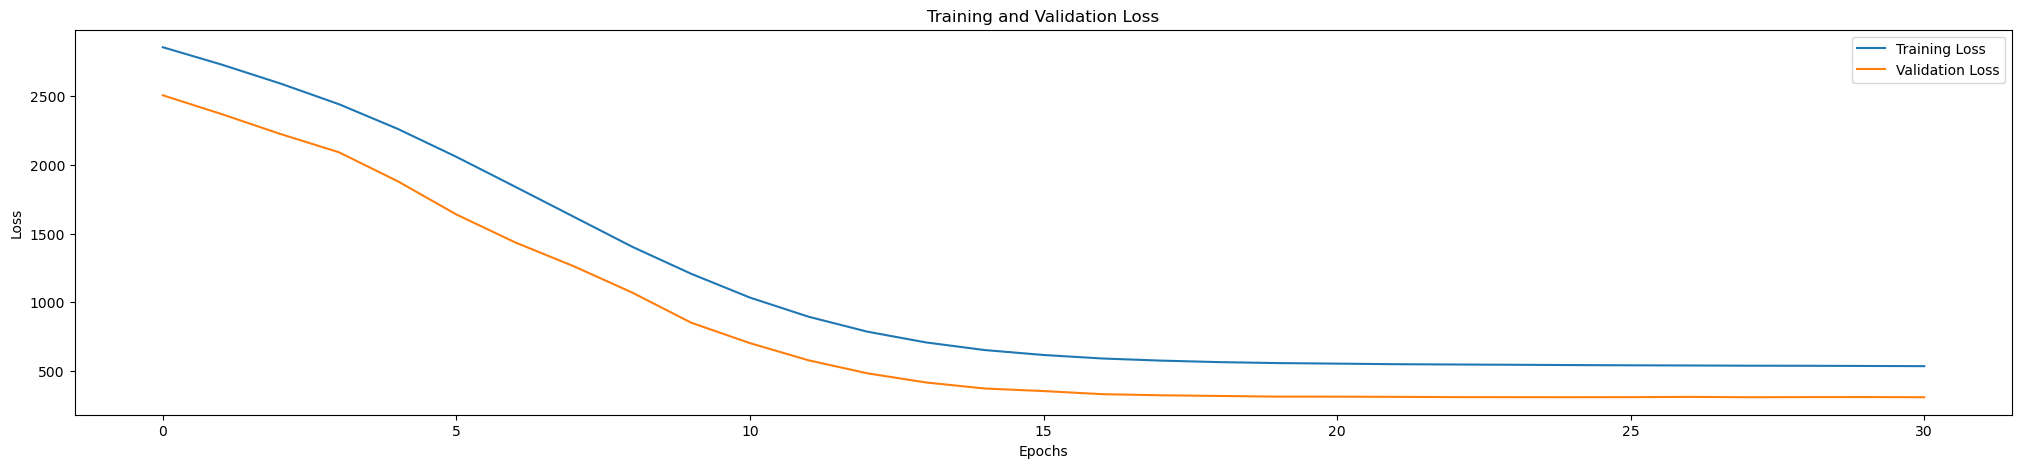

In [79]:
def plot_losses(history):
    train_losses = history['history_train']
    val_losses = history['history_val']

    plt.figure(figsize=(25, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# After training the model
plot_losses(result)


**To run MLFLOW UI**
- proxy can be accessed in studio lab by https://y0mykmepkyacvqd.studio.us-east-2.sagemaker.aws/studiolab/default/jupyter/proxy/6000/

#### **Model Explanation using Lime**

In [95]:
def predict_fn(input_data):
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(input_data, dtype=torch.float32)
        predictions =  model(input_tensor).squeeze().cpu().detach().numpy()
    return predictions


Actual Value: 24.0
Predicted Value: 36.567097


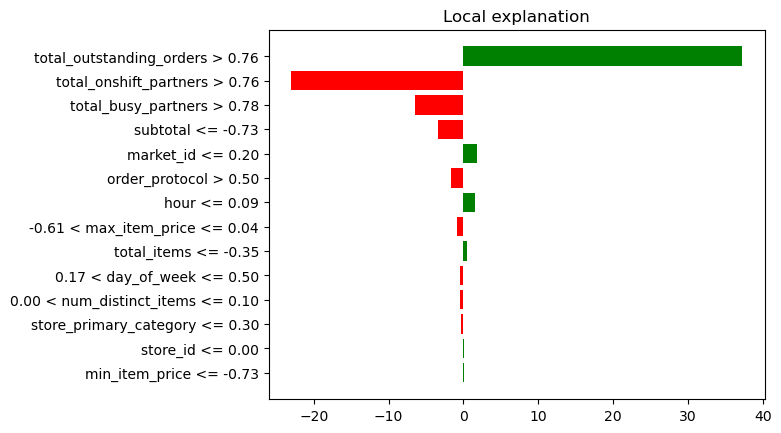

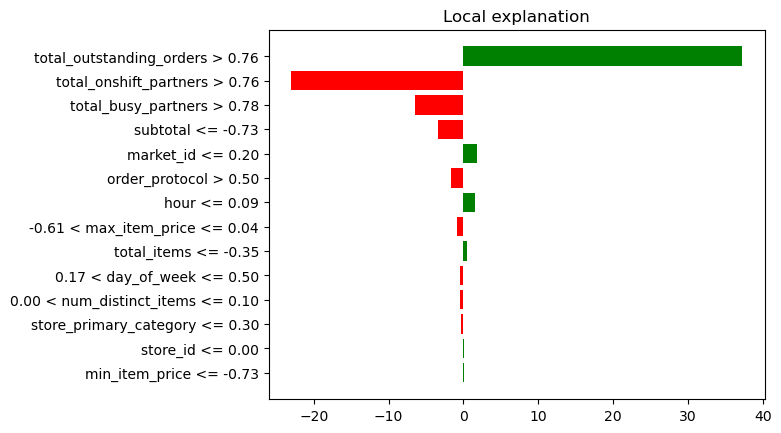

In [121]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.to_numpy(),
                                                   feature_names=X_train.columns.to_list(),
                                                   discretize_continuous=True,
                                                   mode='regression')

n = 17569

instance = X_test.iloc[n].to_numpy()

explanation = explainer.explain_instance(instance, predict_fn, num_features=14)

print("Actual Value:", y_test.iloc[n])
print("Predicted Value:", predict_fn(instance))
explanation.show_in_notebook(show_all=True)
explanation.as_pyplot_figure()


# Insights & Recommendations